In [12]:
import pandas as pd
import numpy as np

# ----------------------
# LOAD DATA
# ----------------------
sales_df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Dataset\Pizza_Sale.csv")
ingredients_df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Dataset\Pizza_ingredients.csv")

# ----------------------
# SALES DATA CLEANING
# ----------------------
sales_clean = sales_df.copy()

# Fill missing categorical values with "Unknown"
for col in ["pizza_name_id", "pizza_name", "pizza_category"]:
    sales_clean[col] = sales_clean[col].fillna("Unknown")

# Recalculate missing total_price = quantity × unit_price
sales_clean["total_price"] = sales_clean.apply(
    lambda row: row["quantity"] * row["unit_price"]
    if pd.isna(row["total_price"]) else row["total_price"],
    axis=1
)

# Convert order_date and order_time to datetime
sales_clean["order_date"] = pd.to_datetime(sales_clean["order_date"], errors="coerce")
sales_clean["order_time"] = pd.to_datetime(sales_clean["order_time"], errors="coerce", format="%H:%M:%S").dt.time

# Combine into one datetime column
sales_clean["order_datetime"] = pd.to_datetime(
    sales_clean["order_date"].astype(str) + " " + sales_clean["order_time"].astype(str),
    errors="coerce"
)

# Drop duplicates
sales_clean.drop_duplicates(inplace=True)

# ----------------------
# INGREDIENTS DATA CLEANING
# ----------------------
ingredients_clean = ingredients_df.copy()

# Impute missing Items_Qty_In_Grams with median per pizza_name_id
ingredients_clean["Items_Qty_In_Grams"] = (
    ingredients_clean.groupby("pizza_name_id")["Items_Qty_In_Grams"]
    .transform(lambda x: x.fillna(x.median()))
)
ingredients_clean["Items_Qty_In_Grams"] = ingredients_clean["Items_Qty_In_Grams"].fillna(
    ingredients_clean["Items_Qty_In_Grams"].median()
)


# ----------------------
# FEATURE ENGINEERING
# ----------------------

# Extract day of week, month, weekend flag
sales_clean["day_of_week"] = sales_clean["order_date"].dt.day_name()
sales_clean["month"] = sales_clean["order_date"].dt.month
sales_clean["is_weekend"] = sales_clean["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

# Aggregate daily sales per pizza
daily_sales = sales_clean.groupby(["order_date", "pizza_name_id"]).agg(
    daily_quantity=("quantity", "sum"),
    daily_revenue=("total_price", "sum")
).reset_index()

# Add rolling 7-day average sales per pizza
daily_sales["rolling_7d_qty"] = daily_sales.groupby("pizza_name_id")["daily_quantity"].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# Add cumulative sales per pizza
daily_sales["cumulative_qty"] = daily_sales.groupby("pizza_name_id")["daily_quantity"].cumsum()

# ----------------------
# MERGE SALES + INGREDIENTS
# ----------------------
merged_data = daily_sales.merge(
    ingredients_clean,
    on="pizza_name_id",
    how="left"
)

# Calculate ingredient demand = daily_quantity × Items_Qty_In_Grams
merged_data["ingredient_demand_grams"] = merged_data["daily_quantity"] * merged_data["Items_Qty_In_Grams"]

# ----------------------
# FINAL CLEANED DATA
# ----------------------
print("✅ Data cleaning & preprocessing complete!")
print(merged_data.head(10))

# Save cleaned dataset for modeling
merged_data.to_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv", index=False)


✅ Data cleaning & preprocessing complete!
  order_date pizza_name_id  daily_quantity  daily_revenue  rolling_7d_qty  \
0 2015-01-01       Unknown               6         101.95             6.0   
1 2015-01-01     bbq_ckn_l               6         124.50             6.0   
2 2015-01-01     bbq_ckn_l               6         124.50             6.0   
3 2015-01-01     bbq_ckn_l               6         124.50             6.0   
4 2015-01-01     bbq_ckn_l               6         124.50             6.0   
5 2015-01-01     bbq_ckn_l               6         124.50             6.0   
6 2015-01-01     bbq_ckn_l               6         124.50             6.0   
7 2015-01-01     bbq_ckn_m               4          67.00             4.0   
8 2015-01-01     bbq_ckn_m               4          67.00             4.0   
9 2015-01-01     bbq_ckn_m               4          67.00             4.0   

   cumulative_qty                  pizza_name  pizza_ingredients  \
0               6                         

In [14]:
import pandas as pd

# Load the cleaned dataset
merged_data = pd.read_csv(
    r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv"
)

# Preview first 10 rows
print(merged_data.head(10))

# Shape of dataset (rows, columns)
print("\nShape:", merged_data.shape)

# Column names
print("\nColumns:", merged_data.columns.tolist())

# Summary of numeric columns
print("\nNumeric Summary:")
print(merged_data.describe())

# Check for missing values
print("\nMissing Values:")
print(merged_data.isnull().sum())


   order_date pizza_name_id  daily_quantity  daily_revenue  rolling_7d_qty  \
0  2015-01-01       Unknown               6         101.95             6.0   
1  2015-01-01     bbq_ckn_l               6         124.50             6.0   
2  2015-01-01     bbq_ckn_l               6         124.50             6.0   
3  2015-01-01     bbq_ckn_l               6         124.50             6.0   
4  2015-01-01     bbq_ckn_l               6         124.50             6.0   
5  2015-01-01     bbq_ckn_l               6         124.50             6.0   
6  2015-01-01     bbq_ckn_l               6         124.50             6.0   
7  2015-01-01     bbq_ckn_m               4          67.00             4.0   
8  2015-01-01     bbq_ckn_m               4          67.00             4.0   
9  2015-01-01     bbq_ckn_m               4          67.00             4.0   

   cumulative_qty                  pizza_name  pizza_ingredients  \
0               6                         NaN                NaN   
1    

✅ Data Loaded
Shape: (51383, 10)
   order_date pizza_name_id  daily_quantity  daily_revenue  rolling_7d_qty  \
0  2015-01-01       Unknown               6         101.95             6.0   
1  2015-01-01     bbq_ckn_l               6         124.50             6.0   
2  2015-01-01     bbq_ckn_l               6         124.50             6.0   
3  2015-01-01     bbq_ckn_l               6         124.50             6.0   
4  2015-01-01     bbq_ckn_l               6         124.50             6.0   

   cumulative_qty                  pizza_name  pizza_ingredients  \
0               6                         NaN                NaN   
1               6  The Barbecue Chicken Pizza  Barbecued Chicken   
2               6  The Barbecue Chicken Pizza        Red Peppers   
3               6  The Barbecue Chicken Pizza      Green Peppers   
4               6  The Barbecue Chicken Pizza           Tomatoes   

   Items_Qty_In_Grams  ingredient_demand_grams  
0                 NaN                   

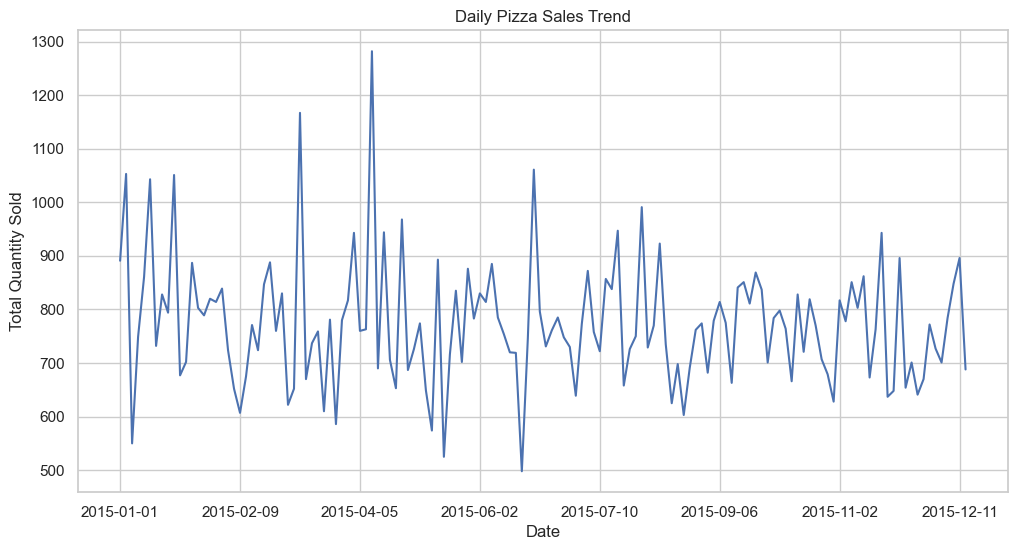

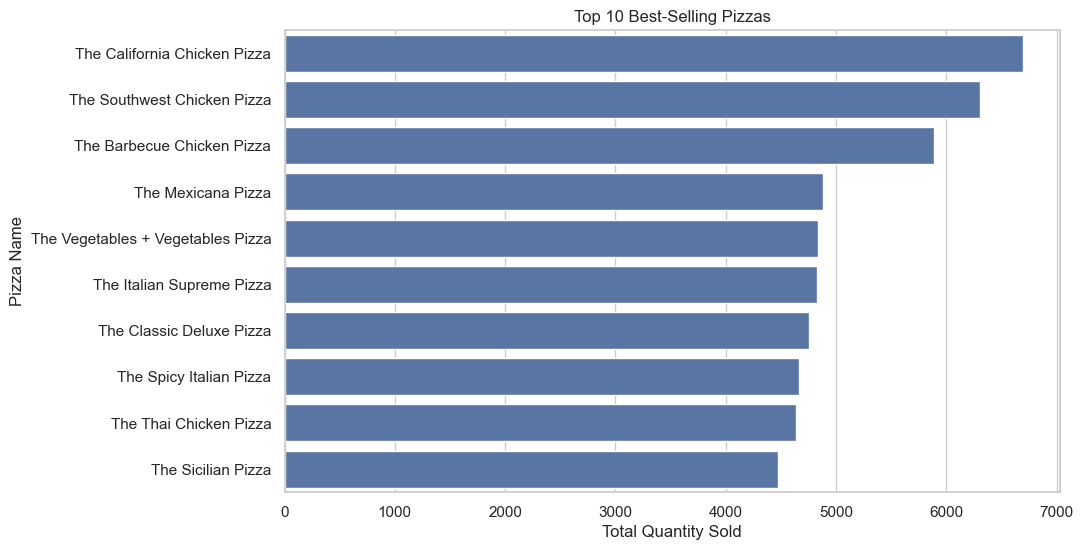

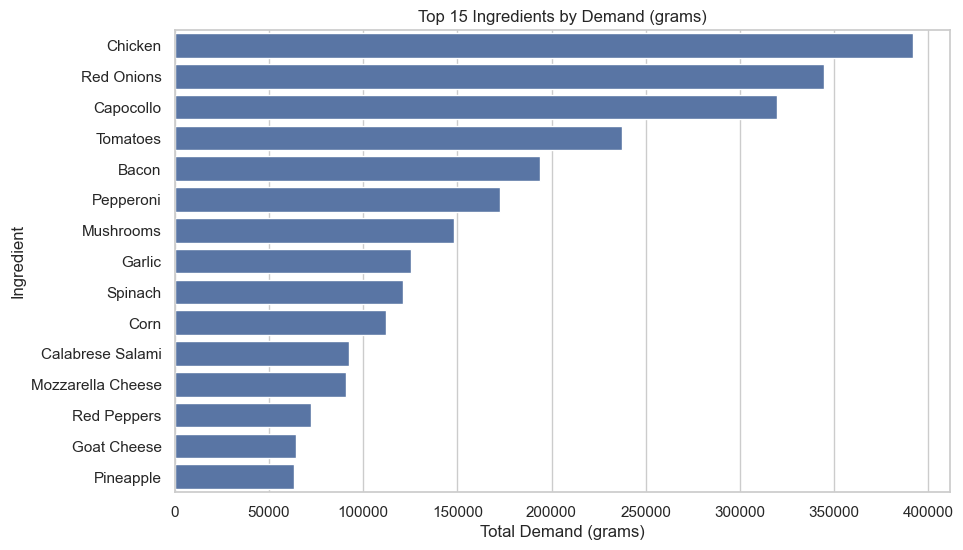

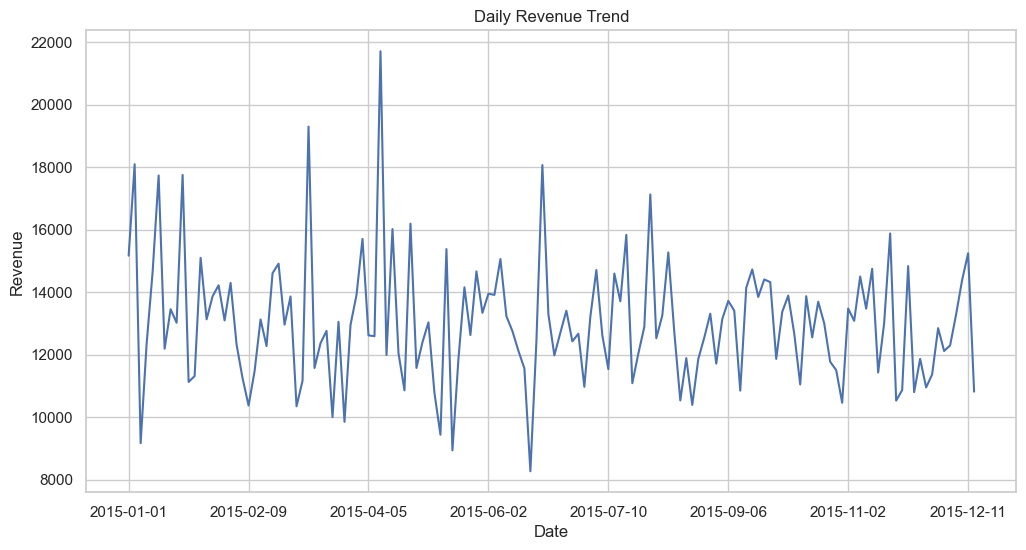

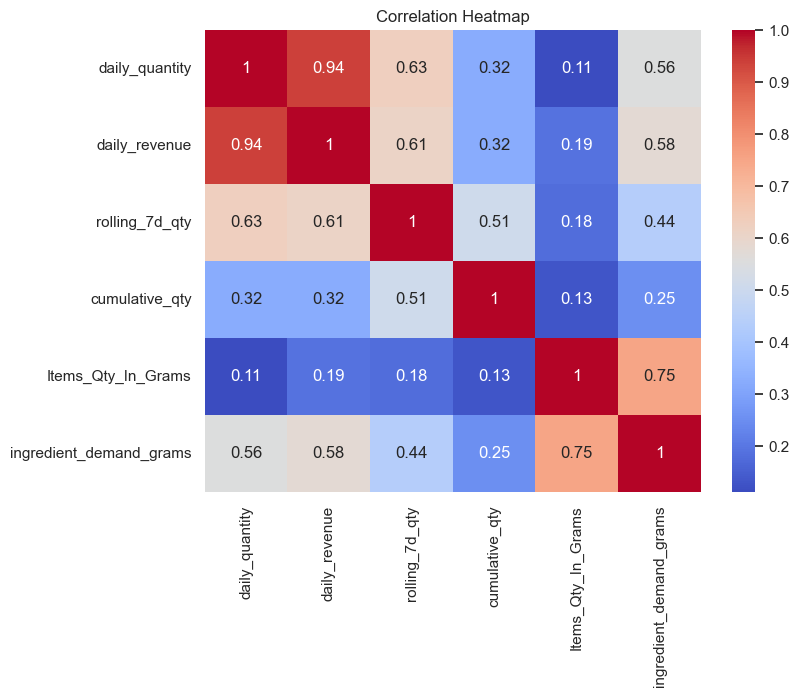

In [18]:
# ----------------------
# 1. IMPORT LIBRARIES
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# ----------------------
# 2. LOAD CLEANED DATA
# ----------------------
merged_data = pd.read_csv(
    r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv"
)

print("✅ Data Loaded")
print("Shape:", merged_data.shape)
print(merged_data.head(5))

# ----------------------
# 3. BASIC DATA CHECKS
# ----------------------
print("\nMissing Values:")
print(merged_data.isnull().sum())

print("\nData Types:")
print(merged_data.dtypes)

print("\nNumeric Summary:")
print(merged_data.describe())

# ----------------------
# 4. SALES TRENDS OVER TIME
# ----------------------
plt.figure(figsize=(12,6))
daily_trend = merged_data.groupby("order_date")["daily_quantity"].sum()
daily_trend.plot()
plt.title("Daily Pizza Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Quantity Sold")
plt.show()

# ----------------------
# 5. TOP-SELLING PIZZAS
# ----------------------
top_pizzas = (
    merged_data.groupby("pizza_name")["daily_quantity"].sum()
    .sort_values(ascending=False).head(10)
)
plt.figure(figsize=(10,6))
sns.barplot(x=top_pizzas.values, y=top_pizzas.index)
plt.title("Top 10 Best-Selling Pizzas")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Pizza Name")
plt.show()

# ----------------------
# 6. INGREDIENT DEMAND ANALYSIS
# ----------------------
ingredient_demand = (
    merged_data.groupby("pizza_ingredients")["ingredient_demand_grams"].sum()
    .sort_values(ascending=False).head(15)
)
plt.figure(figsize=(10,6))
sns.barplot(x=ingredient_demand.values, y=ingredient_demand.index)
plt.title("Top 15 Ingredients by Demand (grams)")
plt.xlabel("Total Demand (grams)")
plt.ylabel("Ingredient")
plt.show()

# ----------------------
# 7. SALES REVENUE TREND
# ----------------------
plt.figure(figsize=(12,6))
merged_data.groupby("order_date")["daily_revenue"].sum().plot()
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# ----------------------
# 8. CORRELATIONS
# ----------------------
plt.figure(figsize=(8,6))
sns.heatmap(merged_data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



In [19]:
# ----------------------
# 1. FEATURE ENGINEERING
# ----------------------
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

# Time-based features
merged_data["year"] = merged_data["order_date"].dt.year
merged_data["month"] = merged_data["order_date"].dt.month
merged_data["week"] = merged_data["order_date"].dt.isocalendar().week
merged_data["day_of_week"] = merged_data["order_date"].dt.day_name()
merged_data["is_weekend"] = merged_data["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

# Aggregate daily sales (all pizzas)
daily_sales = (
    merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()
)
daily_sales = daily_sales.rename(columns={"daily_quantity": "total_daily_sales"})

print(daily_sales.head())


  order_date  total_daily_sales
0 2015-01-01                891
1 2015-01-02               1053
2 2015-01-03                550
3 2015-01-04                749
4 2015-01-05                861


MAPE: 10.80%


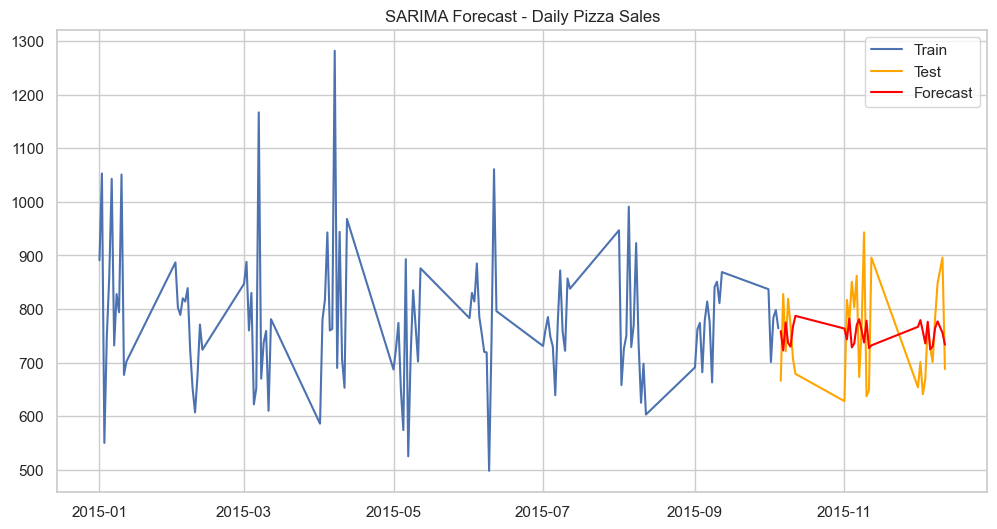

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Train-test split (e.g., last 30 days for testing)
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

# SARIMA model
model = SARIMAX(train["total_daily_sales"], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = model.fit(disp=False)

# Forecast
forecast = sarima_fit.forecast(steps=30)

# Evaluation
mape = mean_absolute_percentage_error(test["total_daily_sales"], forecast) * 100
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.plot(train["order_date"], train["total_daily_sales"], label="Train")
plt.plot(test["order_date"], test["total_daily_sales"], label="Test", color="orange")
plt.plot(test["order_date"], forecast, label="Forecast", color="red")
plt.legend()
plt.title("SARIMA Forecast - Daily Pizza Sales")
plt.show()


18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing


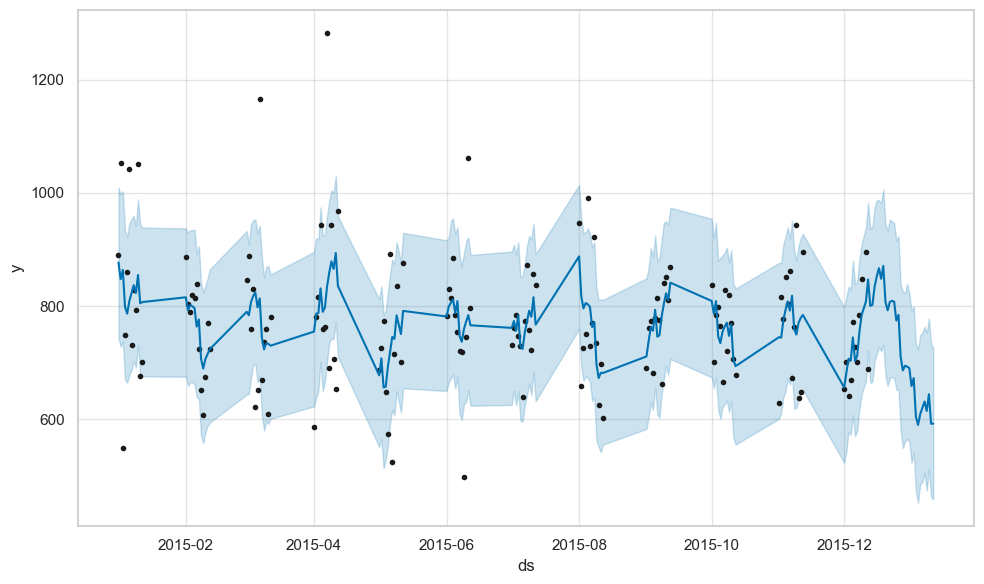

In [22]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = daily_sales.rename(columns={"order_date": "ds", "total_daily_sales": "y"})

# Initialize and fit model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_data)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)


### Sales Forecasting Pipeline

In [23]:
# ----------------------
# 1. FEATURE ENGINEERING
# ----------------------
import pandas as pd

# Aggregate to daily sales
daily_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()
daily_sales["order_date"] = pd.to_datetime(daily_sales["order_date"])
daily_sales = daily_sales.sort_values("order_date")

# Create features
daily_sales["day_of_week"] = daily_sales["order_date"].dt.day_name()
daily_sales["month"] = daily_sales["order_date"].dt.month
daily_sales["is_weekend"] = daily_sales["day_of_week"].isin(["Saturday","Sunday"]).astype(int)

# Rename target for consistency
daily_sales.rename(columns={"daily_quantity": "y"}, inplace=True)

print(daily_sales.head())


  order_date     y day_of_week  month  is_weekend
0 2015-01-01   891    Thursday      1           0
1 2015-01-02  1053      Friday      1           0
2 2015-01-03   550    Saturday      1           1
3 2015-01-04   749      Sunday      1           1
4 2015-01-05   861      Monday      1           0


### SARIMA (Statsmodels)

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Train-Test Split
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

# Fit SARIMA model
sarima_model = SARIMAX(train["y"], order=(2,1,2), seasonal_order=(1,1,1,7))
sarima_result = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_result.forecast(steps=30)

# Evaluation
mape_sarima = mean_absolute_percentage_error(test["y"], sarima_forecast)
print("SARIMA MAPE:", round(mape_sarima*100, 2), "%")


SARIMA MAPE: 10.76 %


### Prophet (Meta)

### Regression Model (RandomForest)

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Encode day_of_week
daily_sales_ml = daily_sales.copy()
daily_sales_ml = pd.get_dummies(daily_sales_ml, columns=["day_of_week"], drop_first=True)

# Features & Target
X = daily_sales_ml.drop(columns=["order_date","y"])
y = daily_sales_ml["y"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

# Train Model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Forecast
rf_forecast = rf.predict(X_test)

# Evaluation
mape_rf = mean_absolute_percentage_error(y_test, rf_forecast)
print("Random Forest MAPE:", round(mape_rf*100, 2), "%")


Random Forest MAPE: 11.28 %


### Compare Models

In [27]:
print("\n📊 Model Performance (MAPE):")
print("SARIMA:", round(mape_sarima*100, 2), "%")
print("Prophet:", round(mape_prophet*100, 2), "%")
print("Random Forest:", round(mape_rf*100, 2), "%")


📊 Model Performance (MAPE):
SARIMA: 10.76 %
Prophet: 9.75 %
Random Forest: 11.28 %


In [25]:
from prophet import Prophet

# Prophet expects "ds" and "y"
prophet_data = daily_sales[["order_date","y"]].rename(columns={"order_date":"ds"})

# Train/Test Split
prophet_train = prophet_data.iloc[:-30]
prophet_test = prophet_data.iloc[-30:]

# Train model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_train)

# Forecast
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Extract forecast for test period
prophet_forecast = forecast.iloc[-30:]["yhat"]

# Evaluation
mape_prophet = mean_absolute_percentage_error(prophet_test["y"], prophet_forecast)
print("Prophet MAPE:", round(mape_prophet*100, 2), "%")


18:34:45 - cmdstanpy - INFO - Chain [1] start processing
18:34:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 9.75 %


### Prophet Loop

In [28]:
from prophet import Prophet
import pandas as pd

# How many days ahead to forecast
FORECAST_DAYS = 7  

# Ensure order_date is datetime
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

# Create empty list to store forecasts
all_forecasts = []

# Loop over each pizza
for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        # Prepare data for Prophet
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        # Skip pizzas with too few data points
        if len(df) < 30:
            continue

        # Train Prophet
        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        # Make future dataframe
        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        # Collect results
        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

# Combine all forecasts
pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

print("✅ Forecasts generated")
print(pizza_forecasts.head())


18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1]

✅ Forecasts generated
  order_date  forecast_qty pizza_name_id
0 2015-12-13      2.381312     bbq_ckn_l
1 2015-12-14     -1.735211     bbq_ckn_l
2 2015-12-15     -0.482547     bbq_ckn_l
3 2015-12-16     -0.582428     bbq_ckn_l
4 2015-12-17      2.102769     bbq_ckn_l


### Map to Ingredients

In [29]:
# Merge forecasts with ingredient mapping
forecast_with_ingredients = pizza_forecasts.merge(
    merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]],
    on="pizza_name_id", how="left"
).drop_duplicates()

# Ingredient demand
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)

print(forecast_with_ingredients.head())


  order_date  forecast_qty pizza_name_id  pizza_ingredients  \
0 2015-12-13      2.381312     bbq_ckn_l  Barbecued Chicken   
1 2015-12-13      2.381312     bbq_ckn_l        Red Peppers   
2 2015-12-13      2.381312     bbq_ckn_l      Green Peppers   
3 2015-12-13      2.381312     bbq_ckn_l           Tomatoes   
4 2015-12-13      2.381312     bbq_ckn_l         Red Onions   

   Items_Qty_In_Grams  ingredient_demand_grams  
0                40.0                95.252467  
1                15.0                35.719675  
2                20.0                47.626233  
3                30.0                71.439350  
4                60.0               142.878700  


### Final Purchase Order

In [30]:
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

# Convert grams to kg
purchase_order["ingredient_demand_kg"] = purchase_order["ingredient_demand_grams"] / 1000

print("✅ Final Purchase Order (next 7 days):")
print(purchase_order.head(15))


✅ Final Purchase Order (next 7 days):
   order_date    pizza_ingredients  ingredient_demand_grams  \
0  2015-12-07         ?duja Salami               149.528309   
1  2015-12-07  Friggitello Peppers                37.382077   
2  2015-12-07               Garlic                37.382077   
3  2015-12-07             Pancetta               224.292463   
4  2015-12-07           Red Onions               149.528309   
5  2015-12-07             Tomatoes                74.764154   
6  2015-12-08         ?duja Salami               109.919255   
7  2015-12-08  Friggitello Peppers                27.479814   
8  2015-12-08               Garlic                27.479814   
9  2015-12-08             Pancetta               164.878883   
10 2015-12-08           Red Onions               109.919255   
11 2015-12-08             Tomatoes                54.959628   
12 2015-12-09         ?duja Salami               249.437783   
13 2015-12-09     Beef Chuck Roast              3270.378935   
14 2015-12-09    

In [32]:
import pandas as pd

# Assuming forecast_with_ingredients is your DataFrame

# 1️⃣ Clean pizza_ingredients column: remove weird characters
forecast_with_ingredients["pizza_ingredients"] = forecast_with_ingredients["pizza_ingredients"].str.replace(
    r"[^a-zA-Z0-9, ]", "", regex=True
).str.strip()  # remove leading/trailing spaces

# 2️⃣ Aggregate ingredient demand by date and ingredient
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

# 3️⃣ Convert grams to kilograms
purchase_order["ingredient_demand_kg"] = (purchase_order["ingredient_demand_grams"] / 1000).round(2)

# 4️⃣ Optional: sort by date and ingredient for readability
purchase_order = purchase_order.sort_values(["order_date", "pizza_ingredients"]).reset_index(drop=True)

# 5️⃣ Display top rows
print("✅ Final Purchase Order (next 7 days):")
print(purchase_order.head(15))

✅ Final Purchase Order (next 7 days):
   order_date    pizza_ingredients  ingredient_demand_grams  \
0  2015-12-07  Friggitello Peppers                37.382077   
1  2015-12-07               Garlic                37.382077   
2  2015-12-07             Pancetta               224.292463   
3  2015-12-07           Red Onions               149.528309   
4  2015-12-07             Tomatoes                74.764154   
5  2015-12-07          duja Salami               149.528309   
6  2015-12-08  Friggitello Peppers                27.479814   
7  2015-12-08               Garlic                27.479814   
8  2015-12-08             Pancetta               164.878883   
9  2015-12-08           Red Onions               109.919255   
10 2015-12-08             Tomatoes                54.959628   
11 2015-12-08          duja Salami               109.919255   
12 2015-12-09     Beef Chuck Roast              3270.378935   
13 2015-12-09          Feta Cheese              1266.929632   
14 2015-12-09    

In [31]:
from prophet import Prophet
import pandas as pd

# =========================
# PARAMETERS
# =========================
FORECAST_DAYS = 7  
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx"

# =========================
# STEP 1 – Preprocess
# =========================
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

all_forecasts = []

# =========================
# STEP 2 – Loop Forecast (Per Pizza)
# =========================
for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        if len(df) < 30:  # skip pizzas with too little data
            continue

        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

# =========================
# STEP 3 – Map to Ingredients
# =========================
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(
    ingredient_map, on="pizza_name_id", how="left"
)

forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)

# =========================
# STEP 4 – Final Purchase Order
# =========================
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

purchase_order["ingredient_demand_kg"] = purchase_order["ingredient_demand_grams"] / 1000

# =========================
# STEP 5 – Export to Excel
# =========================
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Forecasts and Purchase Order saved to {OUTPUT_PATH}")


18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1]

✅ Forecasts and Purchase Order saved to D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx


In [33]:
import pandas as pd
from prophet import Prophet

# =========================
# PARAMETERS
# =========================
FORECAST_DAYS = 7  
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx"

# =========================
# STEP 0 – Clean Ingredients in Original Data
# =========================
# Remove weird characters from pizza_ingredients
merged_data["pizza_ingredients"] = merged_data["pizza_ingredients"].str.replace(
    r"[^a-zA-Z0-9, ]", "", regex=True
).str.strip()

# =========================
# STEP 1 – Preprocess Dates
# =========================
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

all_forecasts = []

# =========================
# STEP 2 – Loop Forecast (Per Pizza)
# =========================
for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        if len(df) < 30:  # skip pizzas with too little data
            continue

        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

# =========================
# STEP 3 – Map to Ingredients
# =========================
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(
    ingredient_map, on="pizza_name_id", how="left"
)

# Optional: Split multiple ingredients per pizza into separate rows
forecast_with_ingredients = forecast_with_ingredients.assign(
    pizza_ingredients=forecast_with_ingredients["pizza_ingredients"].str.split(',')
).explode("pizza_ingredients")

# Remove extra spaces again after splitting
forecast_with_ingredients["pizza_ingredients"] = forecast_with_ingredients["pizza_ingredients"].str.strip()

# Calculate ingredient demand in grams
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)

# =========================
# STEP 4 – Final Purchase Order
# =========================
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

# Convert grams → kilograms and round
purchase_order["ingredient_demand_kg"] = (purchase_order["ingredient_demand_grams"] / 1000).round(2)

# Sort for readability
purchase_order = purchase_order.sort_values(["order_date", "pizza_ingredients"]).reset_index(drop=True)

# =========================
# STEP 5 – Export to Excel
# =========================
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Forecasts and Purchase Order saved to {OUTPUT_PATH}")


18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1]

✅ Forecasts and Purchase Order saved to D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx


In [42]:
print(prophet_forecast.head())
print(prophet_forecast.columns)

  order_date    Prophet
0 2015-12-07   7.476415
1 2015-12-08   5.495963
2 2015-12-09  45.465966
3 2015-12-10  95.151121
4 2015-12-11  97.049975
Index(['order_date', 'Prophet'], dtype='object')


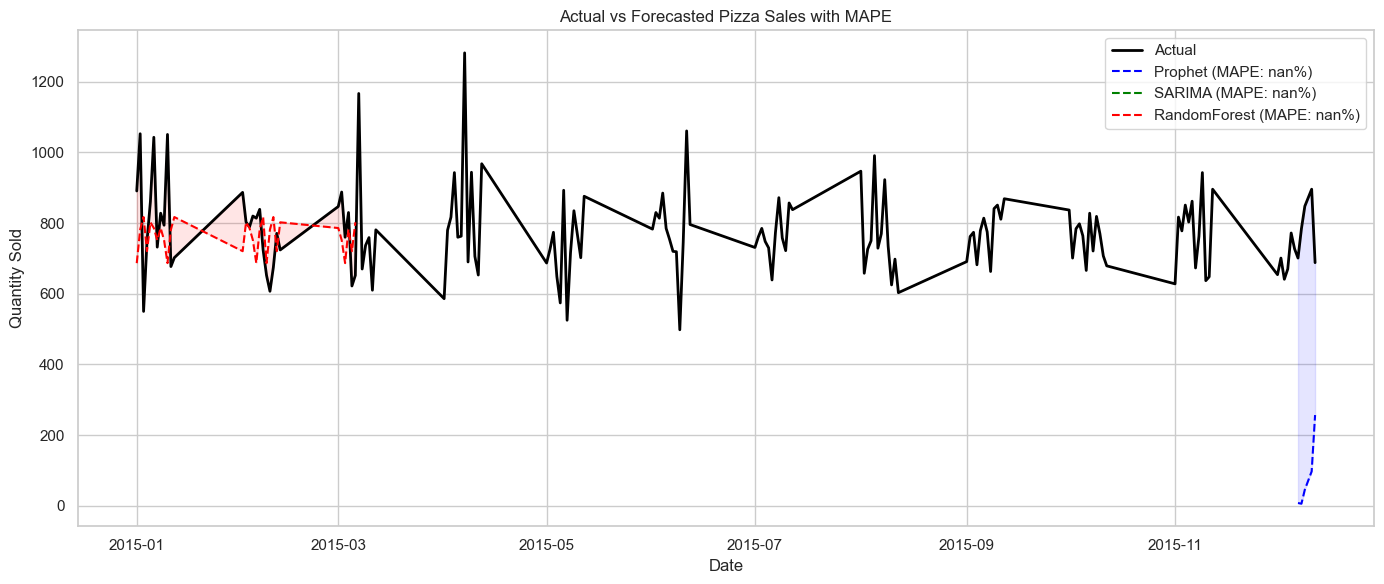

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Step 1 – Aggregate actual sales
# =========================
actual_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()
actual_sales = actual_sales.rename(columns={"daily_quantity": "Actual"})

# =========================
# Step 2 – Function to convert any forecast to DataFrame
# =========================
def forecast_to_df(forecast, name):
    """
    Converts a forecast (DataFrame, Series, or ndarray) into a proper DataFrame with order_date.
    """
    if isinstance(forecast, pd.DataFrame):
        if "order_date" not in forecast.columns:
            forecast = forecast.copy()
            forecast["order_date"] = actual_sales["order_date"].iloc[:len(forecast)]
        forecast = forecast.rename(columns={forecast.columns[1]: name})
        return forecast[["order_date", name]]
    elif isinstance(forecast, (pd.Series, np.ndarray)):
        return pd.DataFrame({
            "order_date": actual_sales["order_date"].iloc[:len(forecast)],
            name: np.array(forecast)
        })
    else:
        raise ValueError(f"Unsupported forecast type: {type(forecast)}")

# Convert all forecasts
# Ensure all order_date columns are datetime
actual_sales["order_date"] = pd.to_datetime(actual_sales["order_date"])
prophet_df["order_date"] = pd.to_datetime(prophet_df["order_date"])
sarima_df["order_date"] = pd.to_datetime(sarima_df["order_date"])
rf_df["order_date"] = pd.to_datetime(rf_df["order_date"])

# Now merge safely
comparison = actual_sales.copy()
for df in [prophet_df, sarima_df, rf_df]:
    comparison = comparison.merge(df, on="order_date", how="left")

# =========================
# Step 3 – Merge all forecasts with actuals
# =========================
comparison = actual_sales.copy()
for df in [prophet_df, sarima_df, rf_df]:
    comparison = comparison.merge(df, on="order_date", how="left")

# =========================
# Step 4 – Calculate MAPE
# =========================
def mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    # Avoid division by zero
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mapes = {}
for model in ["Prophet", "SARIMA", "RandomForest"]:
    mapes[model] = mape(comparison["Actual"], comparison[model])

# =========================
# Step 5 – Plot Actual vs Forecasts with MAPE
# =========================
plt.figure(figsize=(14,6))
plt.plot(comparison['order_date'], comparison['Actual'], label='Actual', color='black', linewidth=2)

colors = {"Prophet": "blue", "SARIMA": "green", "RandomForest": "red"}

for model, color in colors.items():
    plt.plot(comparison['order_date'], comparison[model], linestyle='--', color=color,
             label=f"{model} (MAPE: {mapes[model]:.2f}%)")
    plt.fill_between(comparison['order_date'], comparison['Actual'], comparison[model],
                     color=color, alpha=0.1)

plt.title("Actual vs Forecasted Pizza Sales with MAPE")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Sales Forecasting

In [52]:
from prophet import Prophet
import pandas as pd

FORECAST_DAYS = 7  # Predict next 7 days

# Prepare data for Prophet
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])
all_forecasts = []

for pizza_id, group in merged_data.groupby("pizza_name_id"):
    df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
    df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})
    
    if len(df) < 30:  # Skip pizzas with insufficient history
        continue
    
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(df)
    
    future = model.make_future_dataframe(periods=FORECAST_DAYS)
    forecast = model.predict(future)
    
    forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
    forecast_df["pizza_name_id"] = pizza_id
    forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
    all_forecasts.append(forecast_df)

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)


19:12:48 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing
19:12:48 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:50 - cmdstanpy - INFO - Chain [1] start processing
19:12:50 - cmdstanpy - INFO - Chain [1] done processing
19:12:50 - cmdstanpy - INFO - Chain [1] start processing
19:12:50 - cmdstanpy - INFO - Chain [1]

### Ingredient Calculation

In [53]:
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(
    ingredient_map, on="pizza_name_id", how="left"
)

# Calculate total ingredient demand in grams
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)


### Purchase Order Creation


In [54]:
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

# Convert grams to kilograms
purchase_order["ingredient_demand_kg"] = purchase_order["ingredient_demand_grams"] / 1000

# Optional: Sort by ingredient for clarity
purchase_order = purchase_order.sort_values(["pizza_ingredients", "order_date"])


### Save Results

In [55]:
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx"

with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Forecasts and Purchase Order saved to {OUTPUT_PATH}")


✅ Forecasts and Purchase Order saved to D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx


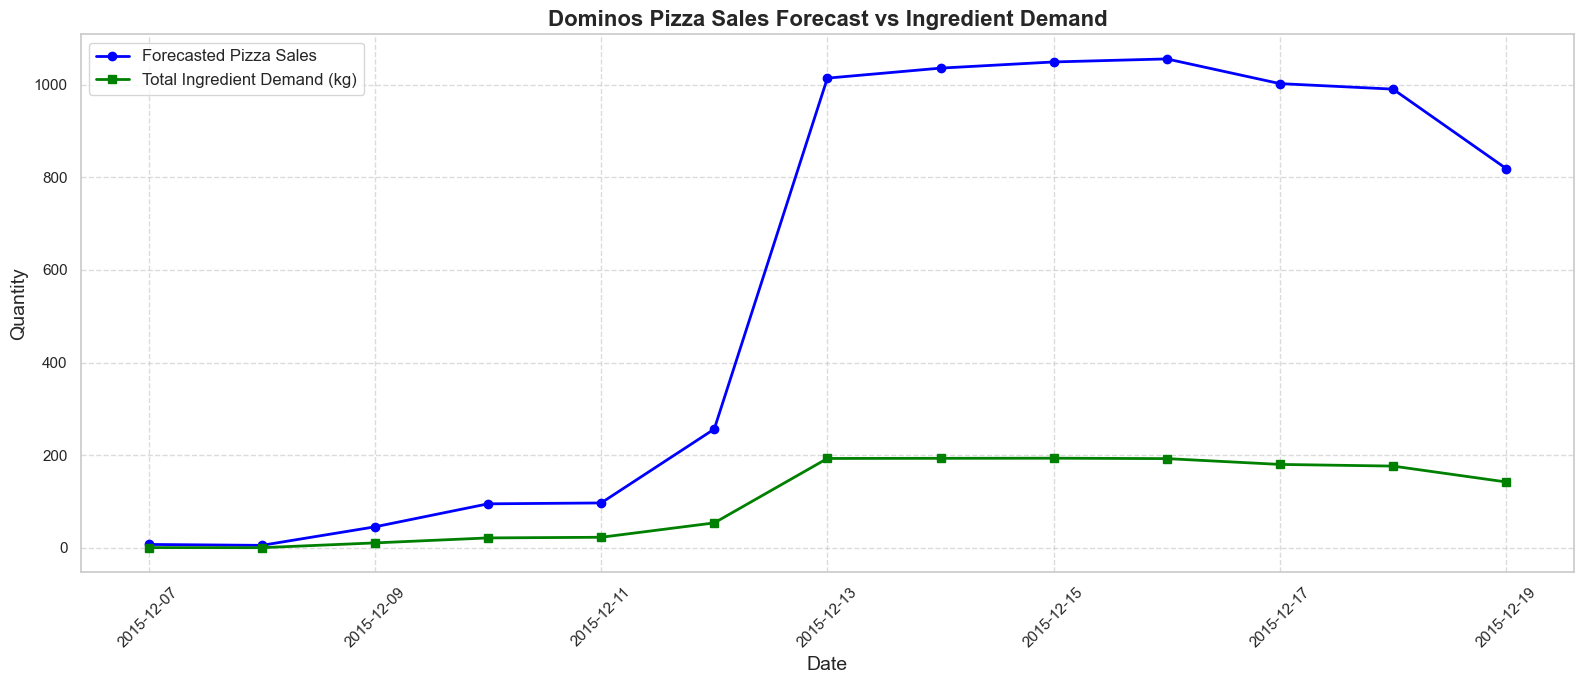

C:\Users\BERLIN SAMUEL RAJ\AppData\Local\Temp\ipykernel_9580\629790354.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ingredients.values, y=top_ingredients.index, palette="viridis")


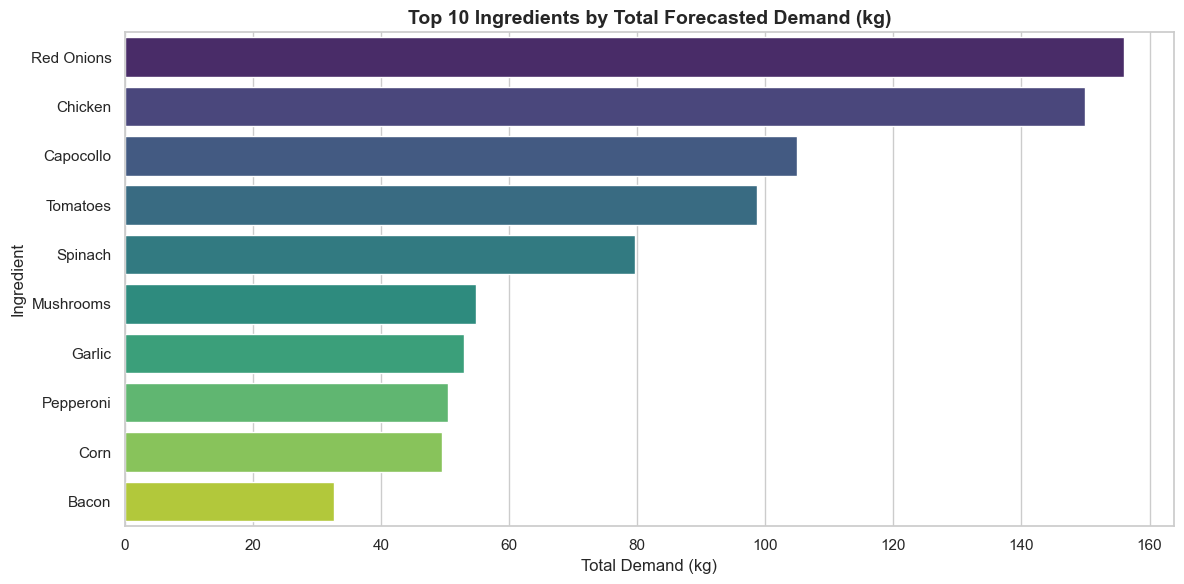

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================
# Step 1 – Aggregate total forecasted pizza sales per day
# =========================
daily_sales_forecast = pizza_forecasts.groupby("order_date")["forecast_qty"].sum().reset_index()
daily_sales_forecast = daily_sales_forecast.rename(columns={"forecast_qty": "Forecasted_Sales"})

# =========================
# Step 2 – Aggregate total ingredient demand per day
# =========================
# Ensure ingredient_demand_kg exists
forecast_with_ingredients["ingredient_demand_kg"] = forecast_with_ingredients["ingredient_demand_grams"] / 1000

# Now aggregate
daily_ingredient_demand = forecast_with_ingredients.groupby("order_date")["ingredient_demand_kg"].sum().reset_index()
# =========================
# Step 3 – Plot Forecast vs Ingredients
# =========================
sns.set(style="whitegrid")
plt.figure(figsize=(16,7))

# Forecasted pizza sales line
plt.plot(daily_sales_forecast["order_date"], daily_sales_forecast["Forecasted_Sales"],
         marker='o', color='blue', label="Forecasted Pizza Sales", linewidth=2)

# Ingredient demand line
plt.plot(daily_ingredient_demand["order_date"], daily_ingredient_demand["ingredient_demand_kg"],
         marker='s', color='green', label="Total Ingredient Demand (kg)", linewidth=2)

# Labels, title, legend
plt.title("Dominos Pizza Sales Forecast vs Ingredient Demand", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Quantity", fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# =========================
# Step 4 – Optional: Top ingredients by total demand
# =========================
top_ingredients = forecast_with_ingredients.groupby("pizza_ingredients")["ingredient_demand_kg"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_ingredients.values, y=top_ingredients.index, palette="viridis")
plt.title("Top 10 Ingredients by Total Forecasted Demand (kg)", fontsize=14, fontweight='bold')
plt.xlabel("Total Demand (kg)", fontsize=12)
plt.ylabel("Ingredient", fontsize=12)
plt.tight_layout()
plt.show()


In [58]:
# =========================
# Domino's Predictive Purchase Order System
# =========================

import pandas as pd
from prophet import Prophet

# =========================
# PARAMETERS
# =========================
FORECAST_DAYS = 7  # Forecast horizon
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx"

# =========================
# STEP 1 – Prepare data
# =========================
# Ensure order_date is datetime
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

# =========================
# STEP 2 – Forecast pizza sales per pizza
# =========================
all_forecasts = []

for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        # Aggregate daily sales per pizza
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        if len(df) < 30:  # Skip pizzas with insufficient data
            continue

        # Train Prophet model
        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        # Forecast next period
        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

# =========================
# STEP 3 – Map forecast to ingredients
# =========================
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(
    ingredient_map, on="pizza_name_id", how="left"
)

# Calculate ingredient demand
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)
forecast_with_ingredients["ingredient_demand_kg"] = forecast_with_ingredients["ingredient_demand_grams"] / 1000

# =========================
# STEP 4 – Generate purchase order
# =========================
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)
purchase_order["ingredient_demand_kg"] = purchase_order["ingredient_demand_grams"] / 1000

# =========================
# STEP 5 – Export to Excel
# =========================
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Forecasts and purchase order saved to: {OUTPUT_PATH}")


19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1]

✅ Forecasts and purchase order saved to: D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx


In [49]:
print(actual_sales['order_date'].dtype)
print(prophet_forecast['order_date'].dtype)

datetime64[ns]
datetime64[ns]


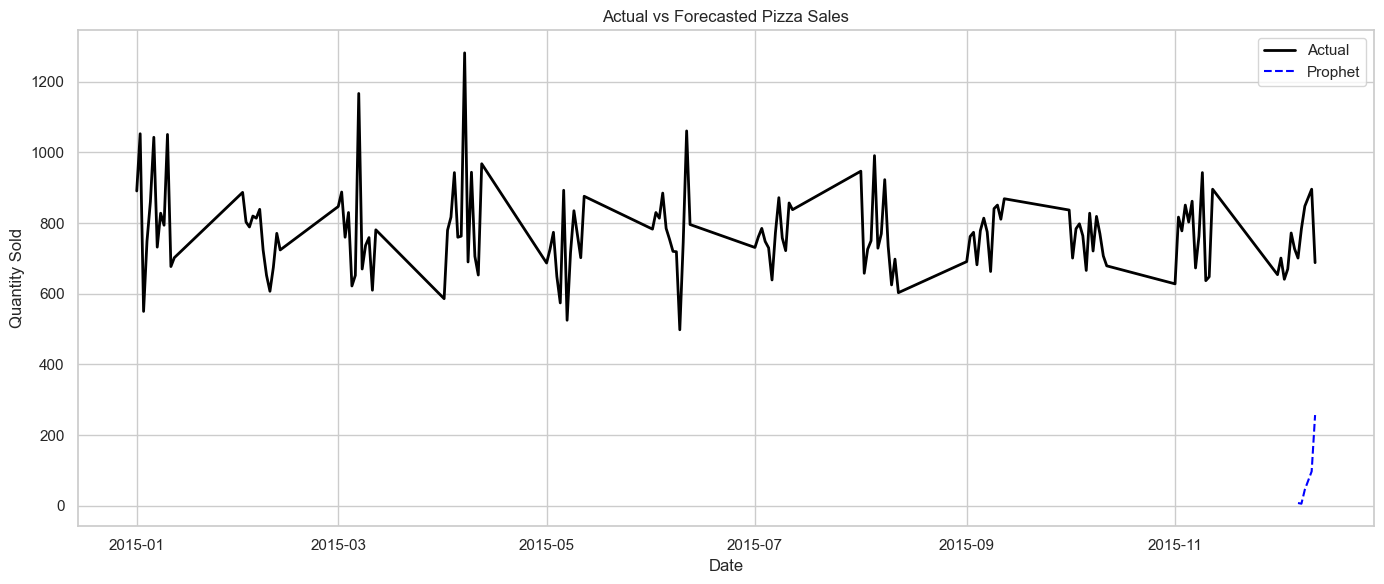

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Step 1 – Prepare Actual Sales
# =========================
# Aggregate total daily sales across all pizzas
actual_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()

# =========================
# Step 2 – Prepare Forecasts
# =========================
# Use your Prophet forecasts (already calculated in pizza_forecasts)
prophet_forecast = pizza_forecasts.groupby("order_date")["forecast_qty"].sum().reset_index()

# Optional: placeholders if you have SARIMA and Random Forest forecasts
# Replace sarima_forecast_df and rf_forecast_df with your actual forecast DataFrames
# sarima_forecast = sarima_forecast_df.groupby("order_date")["forecast_qty"].sum().reset_index()
# rf_forecast = rf_forecast_df.groupby("order_date")["forecast_qty"].sum().reset_index()

# =========================
# Step 3 – Merge DataFrames for Plotting
# =========================
comparison = actual_sales.rename(columns={"daily_quantity": "Actual"})
comparison = comparison.merge(prophet_forecast.rename(columns={"forecast_qty": "Prophet"}), on="order_date", how="left")

# If SARIMA and Random Forest forecasts exist, merge them too
# comparison = comparison.merge(sarima_forecast.rename(columns={"forecast_qty": "SARIMA"}), on="order_date", how="left")
# comparison = comparison.merge(rf_forecast.rename(columns={"forecast_qty": "RandomForest"}), on="order_date", how="left")

# =========================
# Step 4 – Plot
# =========================
plt.figure(figsize=(14,6))
plt.plot(comparison['order_date'], comparison['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(comparison['order_date'], comparison['Prophet'], label='Prophet', linestyle='--', color='blue')

# Uncomment if SARIMA and Random Forest are available
# plt.plot(comparison['order_date'], comparison['SARIMA'], label='SARIMA', linestyle='--', color='green')
# plt.plot(comparison['order_date'], comparison['RandomForest'], label='Random Forest', linestyle='--', color='red')

plt.title("Actual vs Forecasted Pizza Sales")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


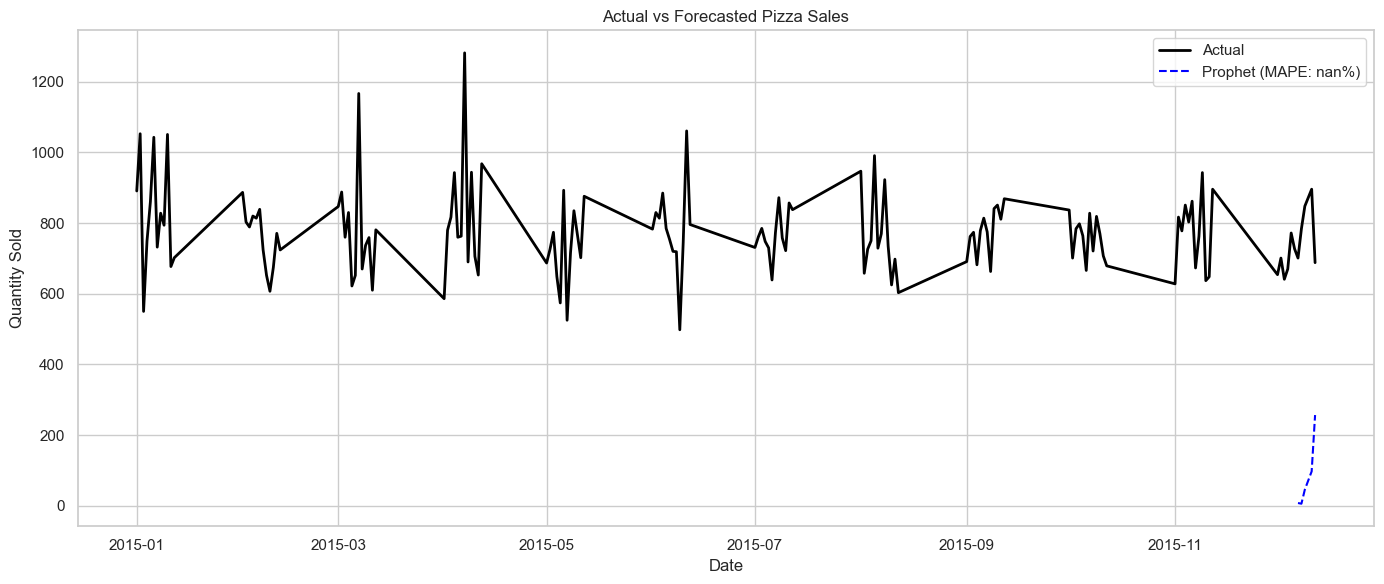

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =========================
# Step 1 – Prepare Actual Sales
# =========================
actual_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()

# =========================
# Step 2 – Prepare Forecasts
# =========================
prophet_forecast = pizza_forecasts.groupby("order_date")["forecast_qty"].sum().reset_index()

# Optional placeholders for SARIMA and Random Forest
# sarima_forecast = sarima_forecast_df.groupby("order_date")["forecast_qty"].sum().reset_index()
# rf_forecast = rf_forecast_df.groupby("order_date")["forecast_qty"].sum().reset_index()

# =========================
# Step 3 – Merge DataFrames
# =========================
comparison = actual_sales.rename(columns={"daily_quantity": "Actual"})
comparison = comparison.merge(prophet_forecast.rename(columns={"forecast_qty": "Prophet"}), on="order_date", how="left")

# Uncomment if SARIMA and RF exist
# comparison = comparison.merge(sarima_forecast.rename(columns={"forecast_qty": "SARIMA"}), on="order_date", how="left")
# comparison = comparison.merge(rf_forecast.rename(columns={"forecast_qty": "RandomForest"}), on="order_date", how="left")

# =========================
# Step 4 – Calculate MAPE
# =========================
def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

prophet_mape = calculate_mape(comparison["Actual"], comparison["Prophet"])
# sarima_mape = calculate_mape(comparison["Actual"], comparison["SARIMA"])
# rf_mape = calculate_mape(comparison["Actual"], comparison["RandomForest"])

# =========================
# Step 5 – Plot with MAPE
# =========================
plt.figure(figsize=(14,6))
plt.plot(comparison['order_date'], comparison['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(comparison['order_date'], comparison['Prophet'], label=f'Prophet (MAPE: {prophet_mape:.2f}%)', linestyle='--', color='blue')

# Uncomment if SARIMA and RF exist
# plt.plot(comparison['order_date'], comparison['SARIMA'], label=f'SARIMA (MAPE: {sarima_mape:.2f}%)', linestyle='--', color='green')
# plt.plot(comparison['order_date'], comparison['RandomForest'], label=f'Random Forest (MAPE: {rf_mape:.2f}%)', linestyle='--', color='red')

plt.title("Actual vs Forecasted Pizza Sales")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# =========================
# DOMINOS PREDICTIVE PURCHASE ORDER PIPELINE
# =========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# =========================
# PARAMETERS
# =========================
FORECAST_DAYS = 7
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx"

# =========================
# LOAD DATA
# =========================
# Replace with your cleaned merged_data CSV
# merged_data = pd.read_csv("merged_data_cleaned.csv")
# Assuming merged_data is already cleaned and loaded

# =========================
# STEP 0 – CLEAN INGREDIENTS
# =========================
merged_data["pizza_ingredients"] = merged_data["pizza_ingredients"].str.replace(
    r"[^a-zA-Z0-9, ]", "", regex=True
).str.strip()

# =========================
# STEP 1 – PRICE EDA
# =========================
# Price Distribution
plt.figure(figsize=(8,5))
sns.histplot(merged_data['price'], bins=30, kde=True)
plt.title('Pizza Price Distribution')
plt.show()

# Price Trend Over Time
merged_data.groupby('order_date')['price'].mean().plot(figsize=(12,5))
plt.title('Average Pizza Price Over Time')
plt.show()

# Price vs Pizza Type
plt.figure(figsize=(12,6))
sns.boxplot(x='pizza_name', y='price', data=merged_data)
plt.xticks(rotation=90)
plt.title('Price Variation by Pizza Type')
plt.show()

# Price vs Promotion
if 'promotion' in merged_data.columns:
    sns.boxplot(x='promotion', y='price', data=merged_data)
    plt.title('Price vs Promotion')
    plt.show()

# =========================
# STEP 2 – FEATURE ENGINEERING
# =========================
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek
merged_data['month'] = merged_data['order_date'].dt.month
merged_data['is_weekend'] = merged_data['day_of_week'].isin([5,6]).astype(int)

# =========================
# STEP 3 – SALES FORECASTING (PER PIZZA)
# =========================
all_forecasts = []

for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        if len(df) < 30:  # skip pizzas with too little data
            continue

        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})

        # Evaluate model on historical data (MAPE)
        mape = mean_absolute_percentage_error(df['y'], forecast['yhat'][:len(df)])
        print(f"{pizza_id} Forecast MAPE: {mape*100:.2f}%")

        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

# =========================
# STEP 4 – MAP TO INGREDIENTS
# =========================
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(
    ingredient_map, on="pizza_name_id", how="left"
)

# Split multiple ingredients per pizza into separate rows
forecast_with_ingredients = forecast_with_ingredients.assign(
    pizza_ingredients=forecast_with_ingredients["pizza_ingredients"].str.split(',')
).explode("pizza_ingredients")

forecast_with_ingredients["pizza_ingredients"] = forecast_with_ingredients["pizza_ingredients"].str.strip()

# Calculate ingredient demand
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)
forecast_with_ingredients["ingredient_demand_kg"] = (
    forecast_with_ingredients["ingredient_demand_grams"] / 1000
).round(2)

# =========================
# STEP 5 – PURCHASE ORDER
# =========================
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

purchase_order = purchase_order.sort_values(["order_date", "pizza_ingredients"]).reset_index(drop=True)

# =========================
# STEP 6 – EXPORT TO EXCEL
# =========================
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Forecasts and Purchase Order saved to {OUTPUT_PATH}")

# =========================
# STEP 7 – OPTIONAL: PRICE-DEMAND CORRELATION
# =========================
if 'price' in merged_data.columns:
    corr = merged_data[['price', 'daily_quantity']].corr().iloc[0,1]
    print(f"Price vs Quantity Correlation: {corr:.2f}")



NameError: name 'merged_data' is not defined

In [4]:
import pandas as pd

# Load the cleaned and encoded sales dataset
merged_data = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv")

# Inspect the first few rows
merged_data.head()

# Optional: check column names
print(merged_data.columns)

Index(['order_date', 'pizza_name_id', 'daily_quantity', 'daily_revenue',
       'rolling_7d_qty', 'cumulative_qty', 'pizza_name', 'pizza_ingredients',
       'Items_Qty_In_Grams', 'ingredient_demand_grams'],
      dtype='object')


In [6]:
print(merged_data.columns)

Index(['order_date', 'pizza_name_id', 'daily_quantity', 'daily_revenue',
       'rolling_7d_qty', 'cumulative_qty', 'pizza_name', 'pizza_ingredients',
       'Items_Qty_In_Grams', 'ingredient_demand_grams'],
      dtype='object')


In [7]:
# Calculate price per pizza
merged_data['price'] = merged_data['daily_revenue'] / merged_data['daily_quantity']

# Check the first few rows to confirm
merged_data.head()

,order_date,pizza_name_id,daily_quantity,daily_revenue,rolling_7d_qty,cumulative_qty,pizza_name,pizza_ingredients,Items_Qty_In_Grams,ingredient_demand_grams,price
0,2015-01-01,Unknown,6,101.95,6.0,6,NaN,NaN,NaN,NaN,16.991667
1,2015-01-01,bbq_ckn_l,6,124.50,6.0,6,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,240.0,20.750000
2,2015-01-01,bbq_ckn_l,6,124.50,6.0,6,The Barbecue Chicken Pizza,Red Peppers,15.0,90.0,20.750000
3,2015-01-01,bbq_ckn_l,6,124.50,6.0,6,The Barbecue Chicken Pizza,Green Peppers,20.0,120.0,20.750000
4,2015-01-01,bbq_ckn_l,6,124.50,6.0,6,The Barbecue Chicken Pizza,Tomatoes,30.0,180.0,20.750000


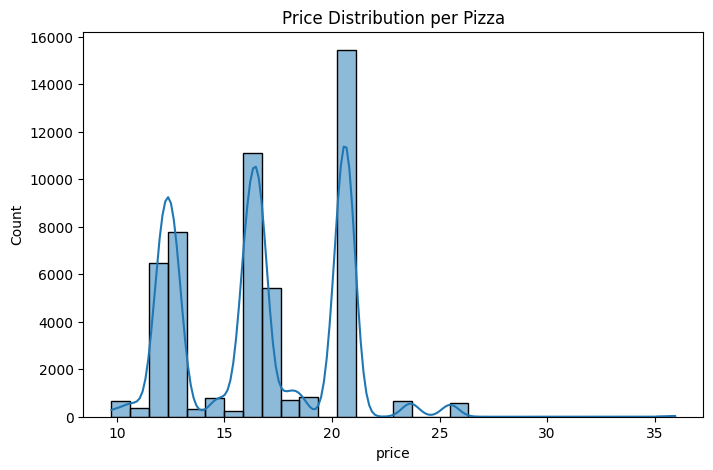

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(merged_data['price'], bins=30, kde=True)
plt.title('Price Distribution per Pizza')
plt.show()


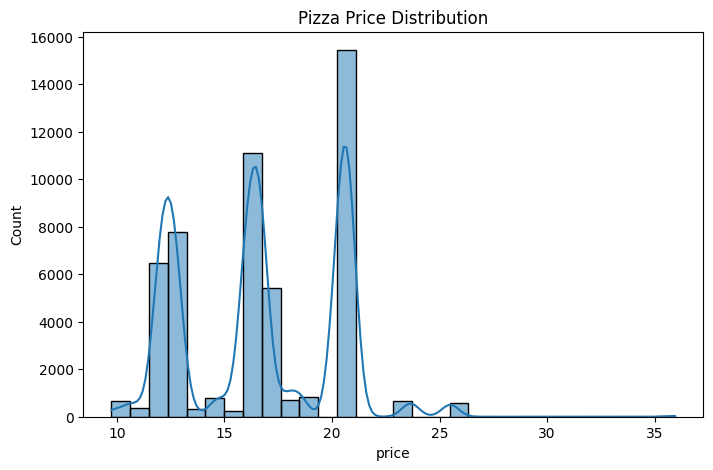

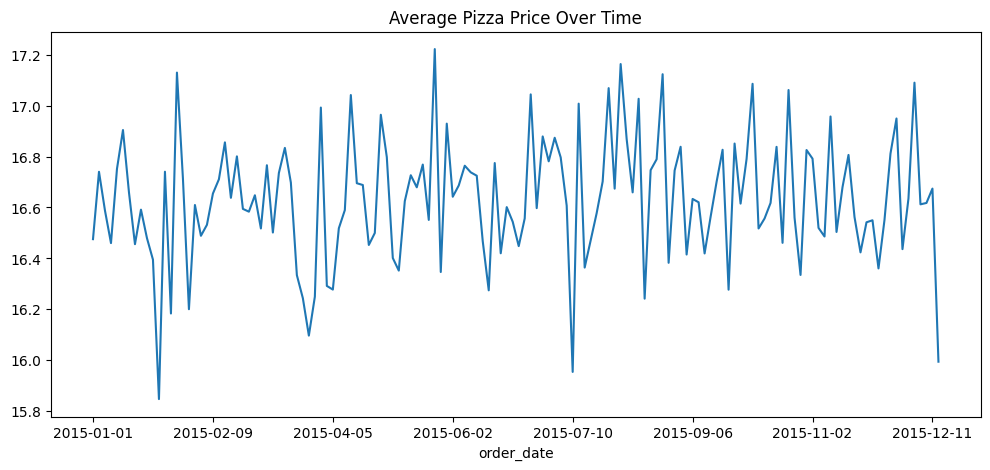

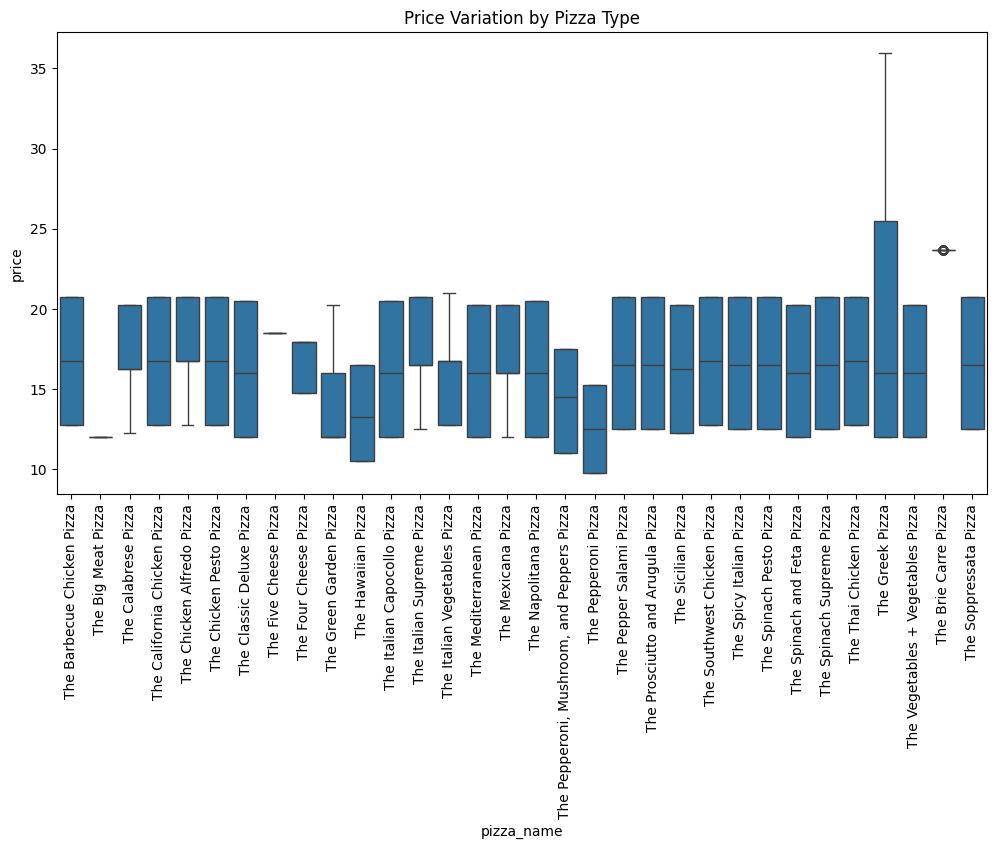

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(merged_data['price'], bins=30, kde=True)
plt.title('Pizza Price Distribution')
plt.show()

# Average price trend over time
merged_data.groupby('order_date')['price'].mean().plot(figsize=(12,5))
plt.title('Average Pizza Price Over Time')
plt.show()

# Price variation by pizza type
plt.figure(figsize=(12,6))
sns.boxplot(x='pizza_name', y='price', data=merged_data)
plt.xticks(rotation=90)
plt.title('Price Variation by Pizza Type')
plt.show()


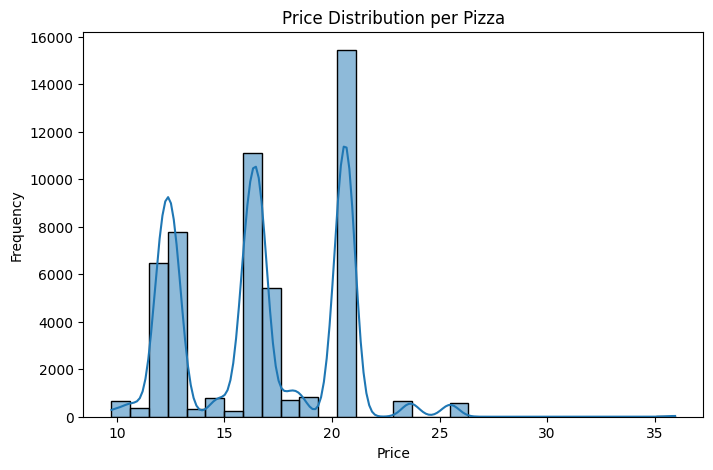

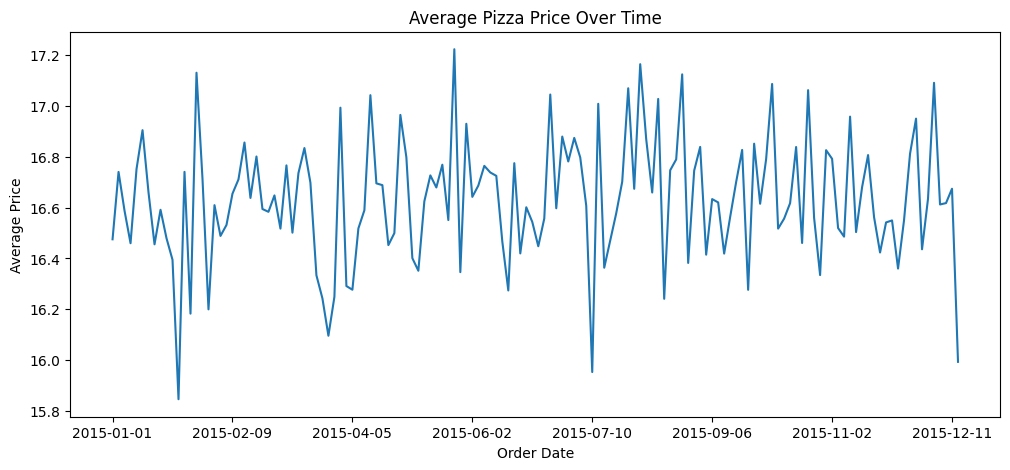

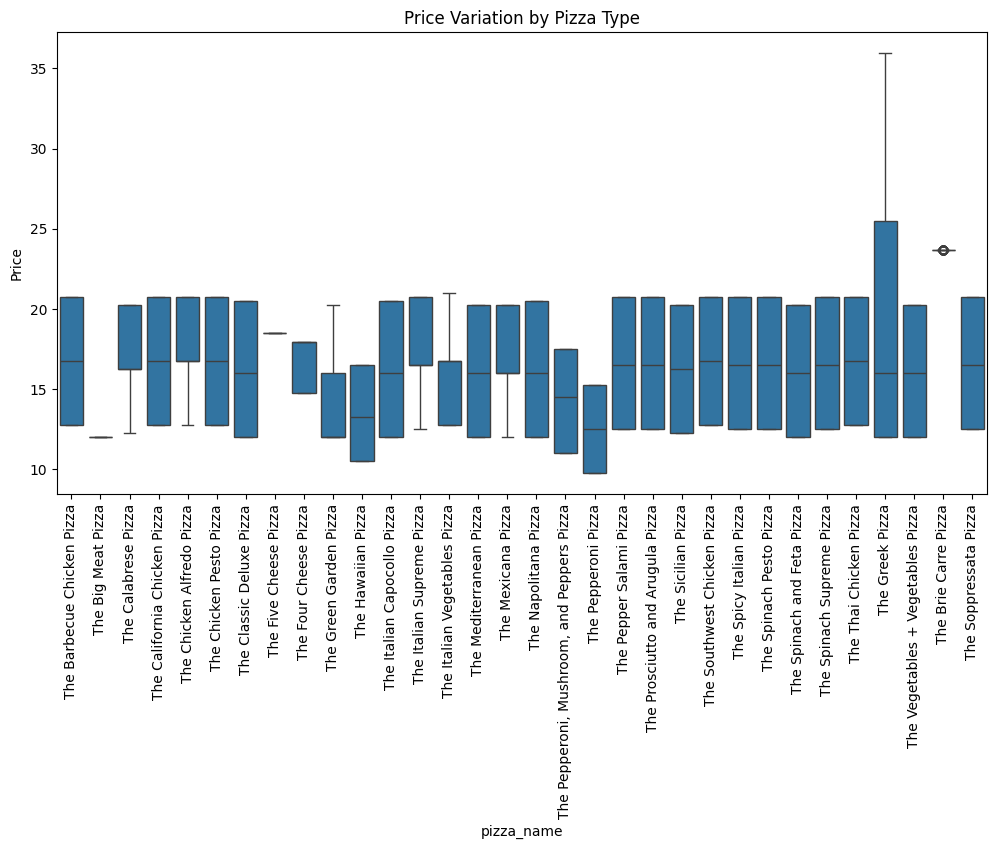

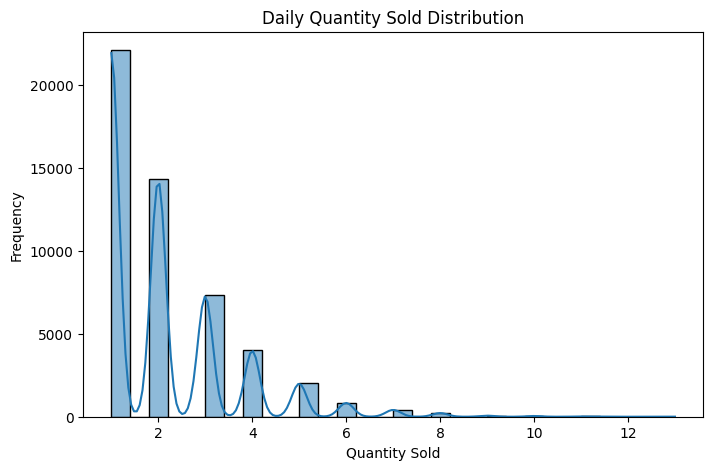

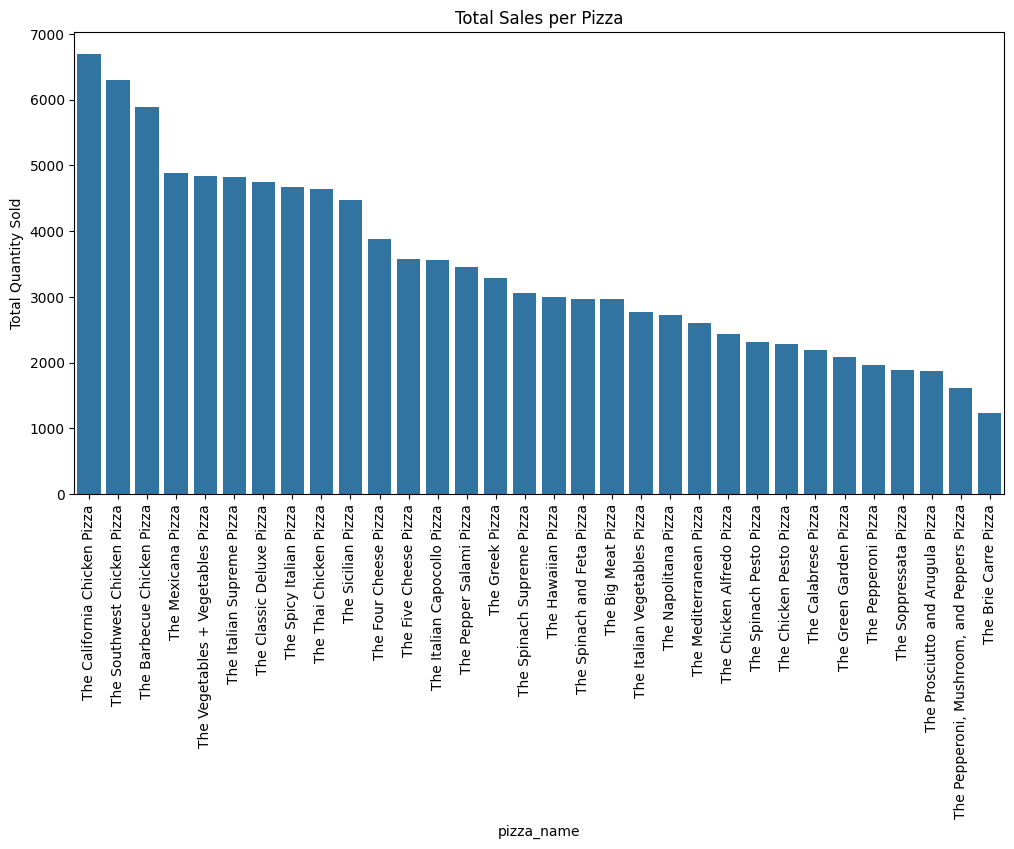

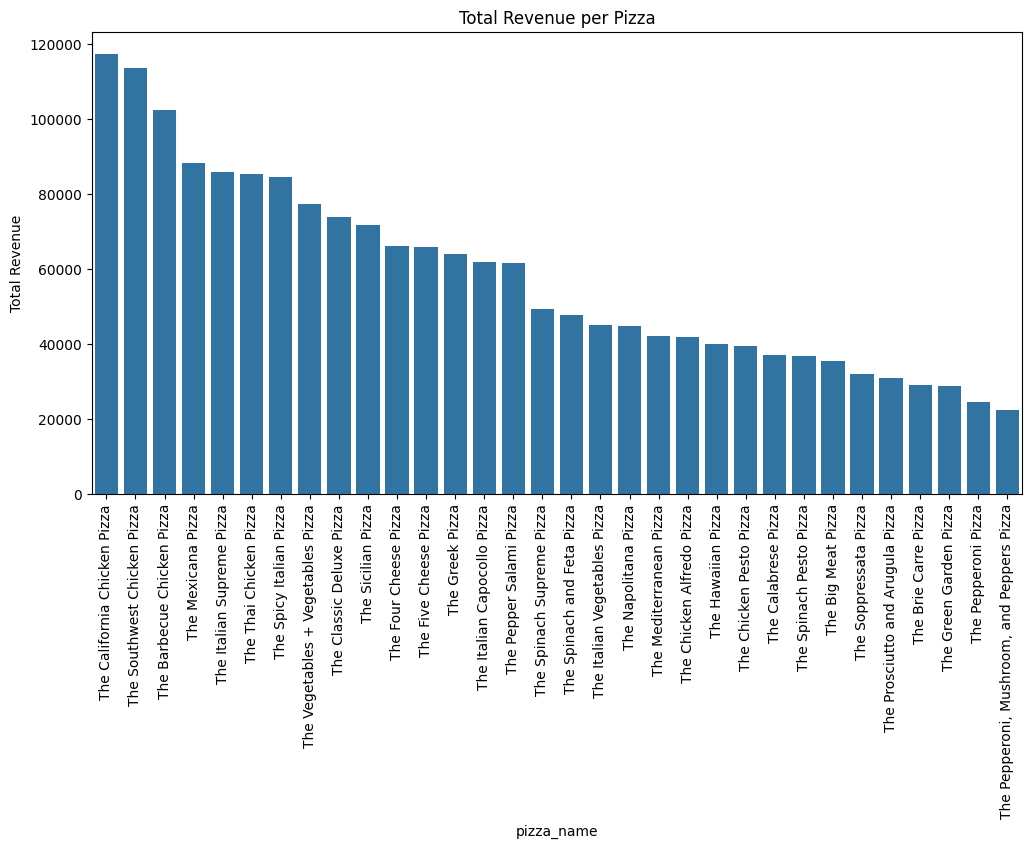

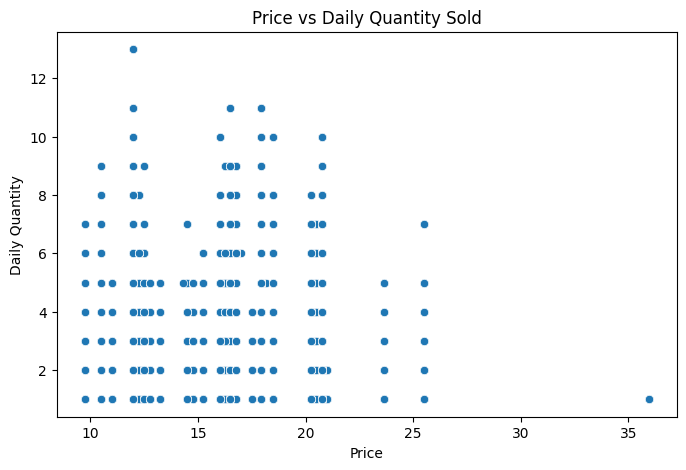

Correlation between price and quantity sold: 0.10


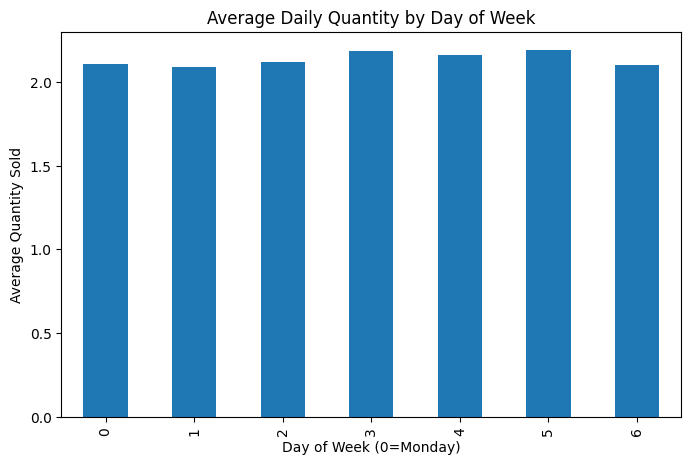

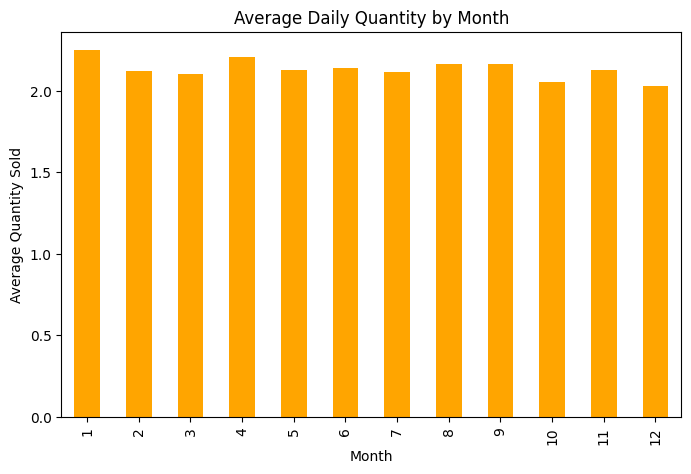

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Ensure price column exists
# =========================
merged_data['price'] = merged_data['daily_revenue'] / merged_data['daily_quantity']

# =========================
# 1️⃣ PRICE EDA
# =========================

# 1.1 Price Distribution
plt.figure(figsize=(8,5))
sns.histplot(merged_data['price'], bins=30, kde=True)
plt.title('Price Distribution per Pizza')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 1.2 Average Price Trend Over Time
merged_data.groupby('order_date')['price'].mean().plot(figsize=(12,5))
plt.title('Average Pizza Price Over Time')
plt.xlabel('Order Date')
plt.ylabel('Average Price')
plt.show()

# 1.3 Price Variation by Pizza Type
plt.figure(figsize=(12,6))
sns.boxplot(x='pizza_name', y='price', data=merged_data)
plt.xticks(rotation=90)
plt.title('Price Variation by Pizza Type')
plt.ylabel('Price')
plt.show()

# =========================
# 2️⃣ SALES EDA
# =========================

# 2.1 Quantity Distribution
plt.figure(figsize=(8,5))
sns.histplot(merged_data['daily_quantity'], bins=30, kde=True)
plt.title('Daily Quantity Sold Distribution')
plt.xlabel('Quantity Sold')
plt.ylabel('Frequency')
plt.show()

# 2.2 Total Sales per Pizza
total_sales = merged_data.groupby('pizza_name')['daily_quantity'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=total_sales.index, y=total_sales.values)
plt.xticks(rotation=90)
plt.title('Total Sales per Pizza')
plt.ylabel('Total Quantity Sold')
plt.show()

# 2.3 Revenue per Pizza
total_revenue = merged_data.groupby('pizza_name')['daily_revenue'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=total_revenue.index, y=total_revenue.values)
plt.xticks(rotation=90)
plt.title('Total Revenue per Pizza')
plt.ylabel('Total Revenue')
plt.show()

# =========================
# 3️⃣ PRICE vs QUANTITY
# =========================
plt.figure(figsize=(8,5))
sns.scatterplot(x='price', y='daily_quantity', data=merged_data)
plt.title('Price vs Daily Quantity Sold')
plt.xlabel('Price')
plt.ylabel('Daily Quantity')
plt.show()

corr = merged_data[['price', 'daily_quantity']].corr().iloc[0,1]
print(f"Correlation between price and quantity sold: {corr:.2f}")

# =========================
# 4️⃣ TIME FEATURES & SALES TRENDS
# =========================
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek
merged_data['month'] = merged_data['order_date'].dt.month
merged_data['is_weekend'] = merged_data['day_of_week'].isin([5,6]).astype(int)

# Average sales per day of week
avg_day_sales = merged_data.groupby('day_of_week')['daily_quantity'].mean()
plt.figure(figsize=(8,5))
avg_day_sales.plot(kind='bar')
plt.title('Average Daily Quantity by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Average Quantity Sold')
plt.show()

# Average sales per month
avg_month_sales = merged_data.groupby('month')['daily_quantity'].mean()
plt.figure(figsize=(8,5))
avg_month_sales.plot(kind='bar', color='orange')
plt.title('Average Daily Quantity by Month')
plt.xlabel('Month')
plt.ylabel('Average Quantity Sold')
plt.show()


19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:37 - cmdstanpy - INFO - Chain [1] done processing
19:34:37 - cmdstanpy - INFO - Chain [1] start processing
19:34:38 - cmdstanpy - INFO - Chain [1] done processing
19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:38 - cmdstanpy - INFO - Chain [1] done processing
19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:38 - cmdstanpy - INFO - Chain [1] done processing
19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:38 - cmdstanpy - INFO - Chain [1] done processing
19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:39 - cmdstanpy - INFO - Chain [1] done processing
19:34:39 - cmdstanpy - INFO - Chain [1] start processing
19:34:39 - cmdstanpy - INFO - Chain [1] done processing
19:34:39 - cmdstanpy - INFO - Chain [1] start processing
19:34:39 - cmdstanpy - INFO - Chain [1] done processing
19:34:39 - cmdstanpy - INFO - Chain [1] start processing
19:34:39 - cmdstanpy - INFO - Chain [1]

📊 Forecast Samples:
  order_date  forecast_qty pizza_name_id
0 2015-12-13      2.381312     bbq_ckn_l
1 2015-12-14     -1.735211     bbq_ckn_l
2 2015-12-15     -0.482547     bbq_ckn_l
3 2015-12-16     -0.582428     bbq_ckn_l
4 2015-12-17      2.102769     bbq_ckn_l

📈 MAPE Results:
   pizza_name_id      MAPE
3     big_meat_s  0.182362
52  prsc_argla_s  0.200850
63  spicy_ital_m  0.274171
38  napolitana_l  0.306418
79   the_greek_s  0.316263


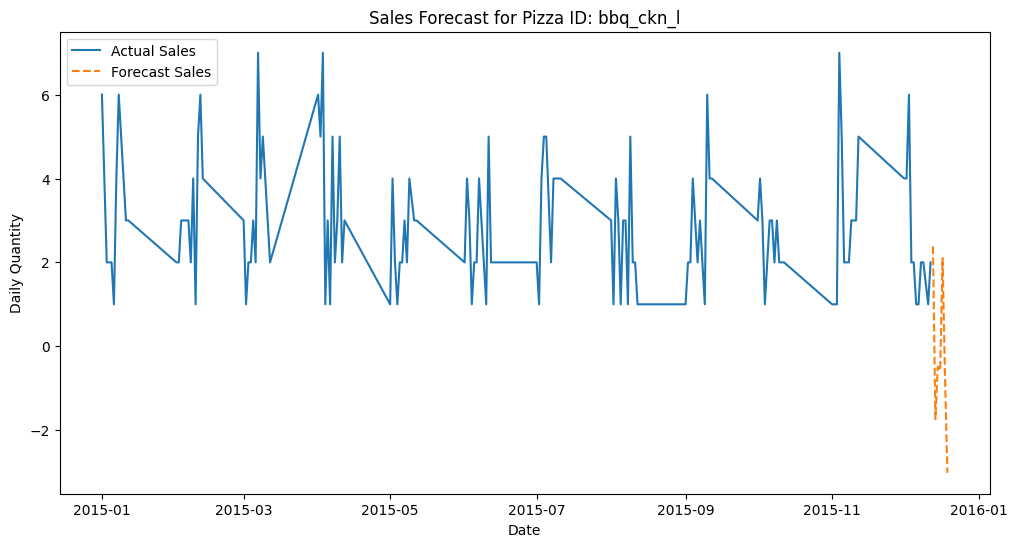

In [11]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# =========================
# PARAMETERS
# =========================
FORECAST_DAYS = 7

# =========================
# STEP 1 – DATA PREP
# =========================
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])
merged_data['price'] = merged_data['daily_revenue'] / merged_data['daily_quantity']

all_forecasts = []
mape_scores = []

# =========================
# STEP 2 – FORECAST PER PIZZA
# =========================
for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        df = group.groupby("order_date")[["daily_quantity"]].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        if len(df) < 60:  # Skip pizzas with too little history
            continue

        # Train Prophet
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        model.fit(df)

        # Future dataframe
        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        # Extract forecast for next 7 days
        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})

        all_forecasts.append(forecast_df)

        # =========================
        # STEP 3 – EVALUATION
        # =========================
        df_train = df.iloc[:-FORECAST_DAYS]
        df_test = df.iloc[-FORECAST_DAYS:]

        future_train = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast_train = model.predict(future_train)
        y_pred = forecast_train["yhat"].iloc[-FORECAST_DAYS:].values

        mape = mean_absolute_percentage_error(df_test["y"], y_pred)
        mape_scores.append({"pizza_name_id": pizza_id, "MAPE": mape})

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

# Combine all forecasts
pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)
mape_results = pd.DataFrame(mape_scores)

# =========================
# STEP 4 – RESULTS
# =========================
print("📊 Forecast Samples:")
print(pizza_forecasts.head())

print("\n📈 MAPE Results:")
print(mape_results.sort_values("MAPE").head())

# =========================
# STEP 5 – VISUALIZATION
# =========================
# Pick a sample pizza to visualize
sample_pizza = pizza_forecasts["pizza_name_id"].iloc[0]
sample_df = merged_data[merged_data["pizza_name_id"] == sample_pizza]

plt.figure(figsize=(12,6))
plt.plot(sample_df["order_date"], sample_df["daily_quantity"], label="Actual Sales")
plt.plot(
    pizza_forecasts[pizza_forecasts["pizza_name_id"] == sample_pizza]["order_date"],
    pizza_forecasts[pizza_forecasts["pizza_name_id"] == sample_pizza]["forecast_qty"],
    label="Forecast Sales",
    linestyle="--"
)
plt.title(f"Sales Forecast for Pizza ID: {sample_pizza}")
plt.xlabel("Date")
plt.ylabel("Daily Quantity")
plt.legend()
plt.show()


In [12]:
# =========================
# Multi-Model Forecasting: Prophet, SARIMA, RandomForest
# =========================

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# PARAMETERS
FORECAST_DAYS = 7
MIN_HISTORY_DAYS = 60  # minimum days per pizza to attempt modelling
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_MultiModel_Forecasts.xlsx"

# Ensure required columns
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])
# derive price if not present
if 'price' not in merged_data.columns:
    merged_data['price'] = merged_data['daily_revenue'] / merged_data['daily_quantity']

# containers
prophet_all = []
sarima_all = []
rf_all = []
mape_records = []

# helper: create feature matrix for RF
def create_rf_features(df_ts):
    """
    df_ts: DataFrame indexed by date with column 'y' and optionally 'price'
    returns X (DataFrame) and y (Series) aligned (rows where lag features not null)
    """
    X = pd.DataFrame(index=df_ts.index)
    X['day_of_week'] = df_ts.index.dayofweek
    X['month'] = df_ts.index.month
    X['is_weekend'] = X['day_of_week'].isin([5,6]).astype(int)
    # include price if available
    if 'price' in df_ts.columns:
        X['price'] = df_ts['price']
    # lag features (1,7,14)
    for lag in [1,7,14]:
        X[f'lag_{lag}'] = df_ts['y'].shift(lag)
    # drop rows with any NaNs (due to lags)
    X = X.dropna()
    y = df_ts['y'].loc[X.index]
    return X, y

# iterate pizzas
pizza_ids = merged_data['pizza_name_id'].unique()
for pizza_id in tqdm(pizza_ids, desc="Pizzas"):
    try:
        grp = merged_data[merged_data['pizza_name_id'] == pizza_id].copy()
        ts = grp.groupby('order_date').agg({
            'daily_quantity': 'sum',
            'price': 'mean'  # average price that day for that pizza (if any)
        }).rename(columns={'daily_quantity':'y'})
        ts = ts.asfreq('D', fill_value=0)  # fill missing dates with 0 sales (safe)
        history_len = len(ts)
        if history_len < MIN_HISTORY_DAYS:
            # skip small series
            continue

        # ============= Prophet ============
        try:
            df_prop = ts['y'].reset_index().rename(columns={'order_date':'ds', 'y':'y'})
            m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
            m.fit(df_prop)
            future = m.make_future_dataframe(periods=FORECAST_DAYS)
            f = m.predict(future)
            # extract next FORECAST_DAYS
            prop_fore = f[['ds','yhat']].tail(FORECAST_DAYS).copy()
            prop_fore['pizza_name_id'] = pizza_id
            prop_fore = prop_fore.rename(columns={'ds':'order_date','yhat':'forecast_qty'})
            prophet_all.append(prop_fore)
        except Exception as e:
            print(f"Prophet failed for {pizza_id}: {e}")

        # ============= SARIMA ============
        try:
            # simple SARIMA with seasonal period 7
            sarima_model = SARIMAX(ts['y'], order=(1,0,1), seasonal_order=(1,0,1,7), enforce_stationarity=False, enforce_invertibility=False)
            sarima_res = sarima_model.fit(disp=False, maxiter=50)
            sarima_pred = sarima_res.get_forecast(steps=FORECAST_DAYS)
            sarima_fore = sarima_pred.predicted_mean.reset_index()
            sarima_fore.columns = ['order_date','forecast_qty']
            sarima_fore['pizza_name_id'] = pizza_id
            sarima_all.append(sarima_fore)
        except Exception as e:
            print(f"SARIMA failed for {pizza_id}: {e}")

        # ============= RANDOM FOREST (feature-based) ============
        try:
            # prepare df_ts with 'y' and 'price' columns aligned to index
            df_ts = ts.copy()
            # create features and target (drops initial rows with NaN due to lags)
            X, y = create_rf_features(df_ts)
            # align train/test split: keep last FORECAST_DAYS for test
            test_idx = y.index[-FORECAST_DAYS:]
            train_idx = y.index[:-FORECAST_DAYS]
            if len(train_idx) < 30:
                # not enough train rows for RF
                raise ValueError("Not enough train samples for RF")
            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_test, y_test = X.loc[test_idx], y.loc[test_idx]

            rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)

            rf_fore = pd.DataFrame({
                'order_date': test_idx,
                'forecast_qty': y_pred
            })
            rf_fore['pizza_name_id'] = pizza_id
            rf_all.append(rf_fore)
        except Exception as e:
            print(f"RandomForest failed for {pizza_id}: {e}")

        # ============= Evaluation (MAPE) ============
        # Use the final FORECAST_DAYS actuals from ts (if available)
        actual_window = ts['y'].iloc[-FORECAST_DAYS:].values

        # Prophet MAPE
        try:
            prop_vals = prop_fore['forecast_qty'].values
            # prophet may produce negative forecasts — clip to zero
            prop_vals = np.maximum(prop_vals, 0)
            mape_prop = mean_absolute_percentage_error(actual_window, prop_vals)
        except Exception:
            mape_prop = np.nan

        # SARIMA MAPE
        try:
            sar_vals = sarima_fore['forecast_qty'].values
            sar_vals = np.maximum(sar_vals, 0)
            mape_sar = mean_absolute_percentage_error(actual_window, sar_vals)
        except Exception:
            mape_sar = np.nan

        # RF MAPE
        try:
            rf_vals = rf_fore['forecast_qty'].values
            rf_vals = np.maximum(rf_vals, 0)
            mape_rf = mean_absolute_percentage_error(actual_window, rf_vals)
        except Exception:
            mape_rf = np.nan

        mape_records.append({
            'pizza_name_id': pizza_id,
            'history_days': history_len,
            'MAPE_Prophet': mape_prop,
            'MAPE_SARIMA': mape_sar,
            'MAPE_RF': mape_rf
        })

    except Exception as outer_e:
        print(f"Skipping pizza {pizza_id} due to outer error: {outer_e}")

# Combine outputs
prophet_df = pd.concat(prophet_all, ignore_index=True) if prophet_all else pd.DataFrame()
sarima_df = pd.concat(sarima_all, ignore_index=True) if sarima_all else pd.DataFrame()
rf_df = pd.concat(rf_all, ignore_index=True) if rf_all else pd.DataFrame()
mape_df = pd.DataFrame(mape_records)

# Tidy columns and ensure datetimes
for df in [prophet_df, sarima_df, rf_df]:
    if not df.empty:
        df['order_date'] = pd.to_datetime(df['order_date'])
        # round forecast_qty to 2 decimals
        df['forecast_qty'] = df['forecast_qty'].astype(float).round(2)

# Show summary MAPE (drop all-nan rows)
print("\n=== MAPE Summary (first 10) ===")
display(mape_df.sort_values('MAPE_Prophet').head(10))

# Optional: Compare average MAPE per model
print("\nAverage MAPE by model (na-ignored):")
print({
    'Prophet': mape_df['MAPE_Prophet'].mean(),
    'SARIMA': mape_df['MAPE_SARIMA'].mean(),
    'RandomForest': mape_df['MAPE_RF'].mean()
})

# Save results to Excel
with pd.ExcelWriter(OUTPUT_PATH, engine='openpyxl') as writer:
    if not prophet_df.empty:
        prophet_df.to_excel(writer, sheet_name='Prophet_Forecasts', index=False)
    if not sarima_df.empty:
        sarima_df.to_excel(writer, sheet_name='SARIMA_Forecasts', index=False)
    if not rf_df.empty:
        rf_df.to_excel(writer, sheet_name='RF_Forecasts', index=False)
    if not mape_df.empty:
        mape_df.to_excel(writer, sheet_name='Model_MAPE_Comparison', index=False)

print(f"\n✅ Forecasts + MAPE comparison exported to: {OUTPUT_PATH}")


Pizzas:   0%|          | 0/92 [00:00<?, ?it/s]18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
Pizzas:   1%|          | 1/92 [00:01<02:30,  1.65s/it]18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
Pizzas:   2%|▏         | 2/92 [00:02<01:41,  1.13s/it]18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
Pizzas:   3%|▎         | 3/92 [00:03<01:22,  1.08it/s]18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
Pizzas:   4%|▍         | 4/92 [00:03<01:12,  1.21it/s]18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
Pizzas:   5%|▌         | 5/92 [00:04<01:07,  1.28it/s]18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
Pizzas


=== MAPE Summary (first 10) ===


,pizza_name_id,history_days,MAPE_Prophet,MAPE_SARIMA,MAPE_RF
53,southw_ckn_m,343,1.487410e+00,3.226980e-01,0.515357
40,pepperoni_l,346,4.178381e+15,9.135689e+14,0.753750
23,hawaiian_m,346,5.381698e+15,1.809664e+15,0.708333
41,pepperoni_m,346,5.725878e+15,7.996704e+14,0.566429
47,prsc_argla_m,345,7.133930e+15,1.500829e+15,0.442857
77,soppressata_m,341,7.419329e+15,3.402731e+15,0.172143
38,pep_msh_pep_m,346,7.635674e+15,2.257438e+15,0.955714
13,classic_dlx_l,346,7.836878e+15,1.569008e+15,0.718571
50,sicilian_m,343,7.919038e+15,3.065011e+15,0.639643
12,ckn_pesto_m,345,8.323283e+15,1.608885e+15,0.296786



Average MAPE by model (na-ignored):
{'Prophet': np.float64(1.993576550380375e+16), 'SARIMA': np.float64(5158278378929653.0), 'RandomForest': np.float64(0.42963265306122445)}

✅ Forecasts + MAPE comparison exported to: D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_MultiModel_Forecasts.xlsx


In [17]:
print("Columns in dataset:")
print(merged_data.columns.tolist())

Columns in dataset:
['order_date', 'pizza_name_id', 'daily_quantity', 'daily_revenue', 'rolling_7d_qty', 'cumulative_qty', 'pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams', 'ingredient_demand_grams']


In [13]:
# ======================
# PRICE PREDICTION MODEL
# ======================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Load your dataset
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv")

# Create target variable
df['price'] = df['daily_revenue'] / df['daily_quantity']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['price'])

# Features for price prediction
features = ['pizza_name', 'pizza_ingredients', 'daily_quantity', 
            'rolling_7d_qty', 'cumulative_qty']

X = df[features].copy()
y = df['price']

# Encode categorical features
le_name = LabelEncoder()
X['pizza_name'] = le_name.fit_transform(X['pizza_name'])

le_ing = LabelEncoder()
X['pizza_ingredients'] = le_ing.fit_transform(X['pizza_ingredients'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest for regression
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)

# Evaluation
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


MAPE: 0.0229
RMSE: 1.0925
R²: 0.9046


In [14]:
# ======================
# PRICE PREDICTION – MODEL COMPARISON
# ======================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost as xgb

# ======================
# LOAD & PREPARE DATA
# ======================
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv")

# Target = price
df['price'] = df['daily_revenue'] / df['daily_quantity']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['price'])

# Features for price prediction
features = ['pizza_name', 'pizza_ingredients', 'daily_quantity', 
            'rolling_7d_qty', 'cumulative_qty']
X = df[features].copy()
y = df['price']

# Encode categorical features
le_name = LabelEncoder()
X['pizza_name'] = le_name.fit_transform(X['pizza_name'])

le_ing = LabelEncoder()
X['pizza_ingredients'] = le_ing.fit_transform(X['pizza_ingredients'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (important for NN, less critical for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======================
# DEFINE MODELS
# ======================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, random_state=42, objective="reg:squarederror"),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
}

# ======================
# TRAIN & EVALUATE
# ======================
results = []

for name, model in models.items():
    if name in ["Linear Regression", "Neural Network"]:
        # Need scaled input
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Tree-based models handle raw features
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, mape, rmse, r2])

# ======================
# SHOW RESULTS
# ======================
results_df = pd.DataFrame(results, columns=["Model", "MAPE", "RMSE", "R²"])
print("\n📊 Model Comparison Results:\n")
print(results_df.sort_values(by="MAPE"))



📊 Model Comparison Results:

               Model      MAPE      RMSE        R²
1      Random Forest  0.022917  1.092910  0.904493
3            XGBoost  0.080288  1.754817  0.753777
2  Gradient Boosting  0.142295  2.732885  0.402818
4     Neural Network  0.155148  3.028207  0.266778
0  Linear Regression  0.182019  3.484667  0.029072


In [15]:
# ======================
# PRICE PREDICTION – SAVE BEST MODEL
# ======================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost as xgb

# ======================
# LOAD & PREPARE DATA
# ======================
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv")

# Target = price
df['price'] = df['daily_revenue'] / df['daily_quantity']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['price'])

# Features for price prediction
features = ['pizza_name', 'pizza_ingredients', 'daily_quantity', 
            'rolling_7d_qty', 'cumulative_qty']
X = df[features].copy()
y = df['price']

# Encode categorical features
le_name = LabelEncoder()
X['pizza_name'] = le_name.fit_transform(X['pizza_name'])

le_ing = LabelEncoder()
X['pizza_ingredients'] = le_ing.fit_transform(X['pizza_ingredients'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (important for NN, less critical for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======================
# DEFINE MODELS
# ======================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, random_state=42, objective="reg:squarederror"),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
}

# ======================
# TRAIN, EVALUATE & SAVE BEST MODEL
# ======================
results = []
best_model = None
best_score = float("inf")  # Lower MAPE is better

for name, model in models.items():
    if name in ["Linear Regression", "Neural Network"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, mape, rmse, r2])

    # Track best model
    if mape < best_score:
        best_score = mape
        best_model = (name, model)

# Results table
results_df = pd.DataFrame(results, columns=["Model", "MAPE", "RMSE", "R²"])
print("\n📊 Model Comparison Results:\n")
print(results_df.sort_values(by="MAPE"))

# ======================
# SAVE BEST MODEL
# ======================
model_name, model_obj = best_model
save_path = rf"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\best_price_model.pkl"
joblib.dump(model_obj, save_path)

print(f"\n✅ Best model: {model_name} (saved at {save_path})")



📊 Model Comparison Results:

               Model      MAPE      RMSE        R²
1      Random Forest  0.022917  1.092910  0.904493
3            XGBoost  0.080288  1.754817  0.753777
2  Gradient Boosting  0.142295  2.732885  0.402818
4     Neural Network  0.155148  3.028207  0.266778
0  Linear Regression  0.182019  3.484667  0.029072

✅ Best model: Random Forest (saved at D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\best_price_model.pkl)


In [17]:
import pandas as pd
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# =========================
# PARAMETERS
# =========================
FORECAST_DAYS = 7  
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Full_Pipeline.xlsx"

# =========================
# STEP 1 – Load Data
# =========================
merged_data = pd.read_csv(
    r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv"
)

# Compute price per pizza
merged_data["price"] = merged_data["daily_revenue"] / merged_data["daily_quantity"]

# Extract features
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])
merged_data["day_of_week"] = merged_data["order_date"].dt.dayofweek
merged_data["month"] = merged_data["order_date"].dt.month

# =========================
# STEP 2 – Train Price Model (Random Forest)
# =========================
X = merged_data[["daily_quantity", "day_of_week", "month", "rolling_7d_qty", "cumulative_qty"]]
y = merged_data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
mape_price = mean_absolute_percentage_error(y_test, y_pred)
print(f"✅ Random Forest Price Model trained. MAPE = {mape_price:.2%}")

# =========================
# STEP 3 – Forecast Sales per Pizza (Prophet)
# =========================
all_forecasts = []

for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        if len(df) < 30:
            continue  # skip low-data pizzas

        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"⚠️ Skipping {pizza_id} due to error: {e}")

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

# =========================
# STEP 4 – Predict Prices for Forecasts
# =========================
pizza_forecasts["day_of_week"] = pizza_forecasts["order_date"].dt.dayofweek
pizza_forecasts["month"] = pizza_forecasts["order_date"].dt.month

pizza_forecasts["rolling_7d_qty"] = pizza_forecasts.groupby("pizza_name_id")["forecast_qty"].transform(lambda x: x.rolling(7, min_periods=1).mean())
pizza_forecasts["cumulative_qty"] = pizza_forecasts.groupby("pizza_name_id")["forecast_qty"].cumsum()

# Rename forecast_qty → daily_quantity (to match training features)
X_future = pizza_forecasts.rename(columns={"forecast_qty": "daily_quantity"})[
    ["daily_quantity", "day_of_week", "month", "rolling_7d_qty", "cumulative_qty"]
].fillna(0)

# Predict prices
pizza_forecasts["forecast_price"] = rf_model.predict(X_future)

# Calculate revenue
pizza_forecasts["forecast_revenue"] = pizza_forecasts["forecast_qty"] * pizza_forecasts["forecast_price"]

# =========================
# STEP 5 – Map to Ingredients
# =========================
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(ingredient_map, on="pizza_name_id", how="left")

# Split ingredients into separate rows
forecast_with_ingredients = forecast_with_ingredients.assign(
    pizza_ingredients=forecast_with_ingredients["pizza_ingredients"].str.split(",")
).explode("pizza_ingredients")

forecast_with_ingredients["pizza_ingredients"] = forecast_with_ingredients["pizza_ingredients"].str.strip()

# Ingredient demand
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)

# =========================
# STEP 6 – Final Purchase Order
# =========================
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

purchase_order["ingredient_demand_kg"] = (purchase_order["ingredient_demand_grams"] / 1000).round(2)

# =========================
# STEP 7 – Export Results
# =========================
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    forecast_with_ingredients.to_excel(writer, sheet_name="Forecast_w_Ingredients", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Full pipeline completed. Results saved to {OUTPUT_PATH}")


18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing


✅ Random Forest Price Model trained. MAPE = 22.06%


18:22:07 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing
18:22:07 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing
18:22:07 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing
18:22:07 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing
18:22:07 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1]

✅ Full pipeline completed. Results saved to D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Full_Pipeline.xlsx


18:29:10 - cmdstanpy - INFO - Chain [1] start processing
18:29:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAPE: 0.0973, RMSE: 83.8497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

📊 Sales Forecast Model Comparison:
     Model      MAPE       RMSE
0  Prophet  0.097258  83.849652
1   SARIMA  0.107614  94.781071
2     LSTM  0.106626  89.559909


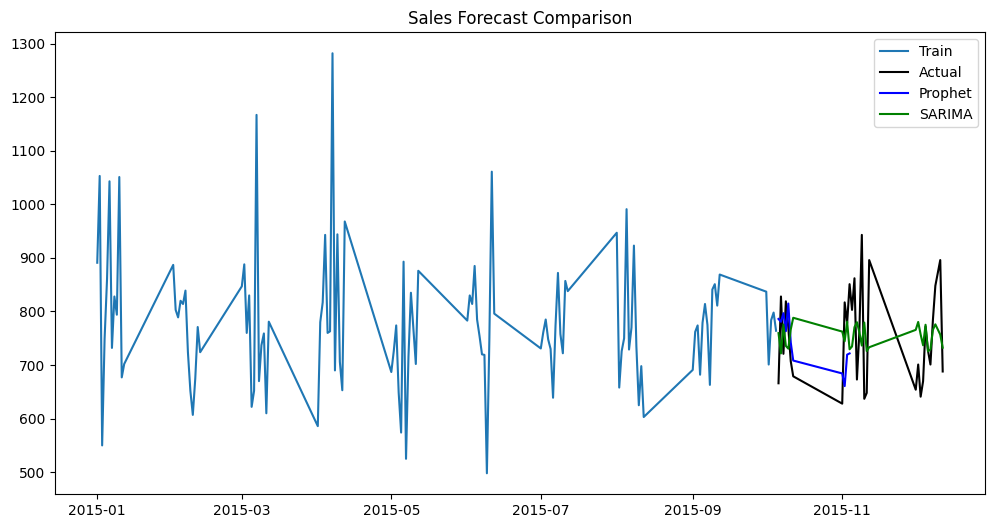

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt
from prophet import Prophet
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# =====================
# 1. PREPARE DATA
# =====================
df = merged_data.copy()
df["order_date"] = pd.to_datetime(df["order_date"])

# Aggregate sales per day (total across pizzas)
daily_sales = df.groupby("order_date")["daily_quantity"].sum().reset_index()
daily_sales = daily_sales.rename(columns={"order_date": "ds", "daily_quantity": "y"})

# Train-test split (last 30 days for test)
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

# =====================
# 2. PROPHET
# =====================
# Prophet model
prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet.fit(train)

future = prophet.make_future_dataframe(periods=len(test))
forecast = prophet.predict(future)

# Merge forecast with test set
prophet_results = forecast[["ds", "yhat"]].merge(test, on="ds", how="inner")

# Extract predictions and actuals
prophet_pred = prophet_results["yhat"].values
prophet_actual = prophet_results["y"].values

# Calculate metrics
prophet_mape = mean_absolute_percentage_error(prophet_actual, prophet_pred)
prophet_rmse = sqrt(mean_squared_error(prophet_actual, prophet_pred))

print(f"Prophet - MAPE: {prophet_mape:.4f}, RMSE: {prophet_rmse:.4f}")


# =====================
# 3. SARIMA
# =====================
sarima_model = sm.tsa.statespace.SARIMAX(train["y"], order=(2,1,2), seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit(disp=False)

sarima_pred = sarima_fit.forecast(steps=30)

sarima_mape = mean_absolute_percentage_error(test["y"], sarima_pred)
sarima_rmse = sqrt(mean_squared_error(test["y"], sarima_pred))

# =====================
# 4. LSTM
# =====================
scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily_sales[["y"]])

# Create sequences
def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 7
X, y = create_sequences(scaled, seq_len)

# Split train/test
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build model
lstm_model = Sequential([
    LSTM(50, activation="relu", input_shape=(seq_len, 1)),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=0)

# Predict
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

y_test_inv = scaler.inverse_transform(y_test)

lstm_mape = mean_absolute_percentage_error(y_test_inv, lstm_pred)
lstm_rmse = sqrt(mean_squared_error(y_test_inv, lstm_pred))

# =====================
# 5. RESULTS TABLE
# =====================
results = pd.DataFrame({
    "Model": ["Prophet", "SARIMA", "LSTM"],
    "MAPE": [prophet_mape, sarima_mape, lstm_mape],
    "RMSE": [prophet_rmse, sarima_rmse, lstm_rmse]
})

print("\n📊 Sales Forecast Model Comparison:")
print(results)

# =====================
# 6. PLOT COMPARISON
# =====================
plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train")

# Actual test data
plt.plot(test["ds"], test["y"], label="Actual", color="black")

# Prophet (use prophet_results which has matching dates)
plt.plot(prophet_results["ds"], prophet_results["yhat"], label="Prophet", color="blue")

# SARIMA (aligned with test already)
plt.plot(test["ds"], sarima_pred, label="SARIMA", color="green")

# If LSTM is included:
# plt.plot(test["ds"], lstm_pred, label="LSTM", color="red")

plt.legend()
plt.title("Sales Forecast Comparison")
plt.show()



In [23]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# Detect the right datetime column
if "date" in df.columns:
    date_col = "date"
elif "order_date" in df.columns:
    date_col = "order_date"
elif "ds" in df.columns:
    date_col = "ds"
else:
    raise KeyError("No suitable date column found! Expected one of: ['date', 'order_date', 'ds'].")

# Ensure datetime type
df[date_col] = pd.to_datetime(df[date_col])

# ---------------------------
# 1. Basic calendar features
# ---------------------------
df["day_of_week"] = df[date_col].dt.dayofweek   # 0=Mon ... 6=Sun
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df[date_col].dt.month
df["year"] = df[date_col].dt.year

# ---------------------------
# 2. Holiday features
# ---------------------------
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df[date_col].min(), end=df[date_col].max())
df["is_holiday"] = df[date_col].isin(holidays).astype(int)

# ---------------------------
# 3. Lag/rolling features
# ---------------------------
if "pizza_id" in df.columns and "quantity" in df.columns:
    df["lag_1d"] = df.groupby("pizza_id")["quantity"].shift(1)
    df["lag_7d"] = df.groupby("pizza_id")["quantity"].shift(7)
    df["rolling_7d"] = df.groupby("pizza_id")["quantity"].shift(1).rolling(7).mean()

print(df.head())



  order_date pizza_name_id  daily_quantity  daily_revenue  rolling_7d_qty  \
0 2015-01-01       Unknown               6         101.95             6.0   
1 2015-01-01     bbq_ckn_l               6         124.50             6.0   
2 2015-01-01     bbq_ckn_l               6         124.50             6.0   
3 2015-01-01     bbq_ckn_l               6         124.50             6.0   
4 2015-01-01     bbq_ckn_l               6         124.50             6.0   

   cumulative_qty                  pizza_name  pizza_ingredients  \
0               6                         NaN                NaN   
1               6  The Barbecue Chicken Pizza  Barbecued Chicken   
2               6  The Barbecue Chicken Pizza        Red Peppers   
3               6  The Barbecue Chicken Pizza      Green Peppers   
4               6  The Barbecue Chicken Pizza           Tomatoes   

   Items_Qty_In_Grams  ingredient_demand_grams      price  day_of_week  month  \
0                 NaN                      NaN 

23:04:21 - cmdstanpy - INFO - Chain [1] start processing
23:04:21 - cmdstanpy - INFO - Chain [1] done processing


Model Comparison (MAPE, RMSE):
Prophet: 0.092, 76.60
SARIMA: 0.108, 94.88
LSTM:   0.111, 92.37


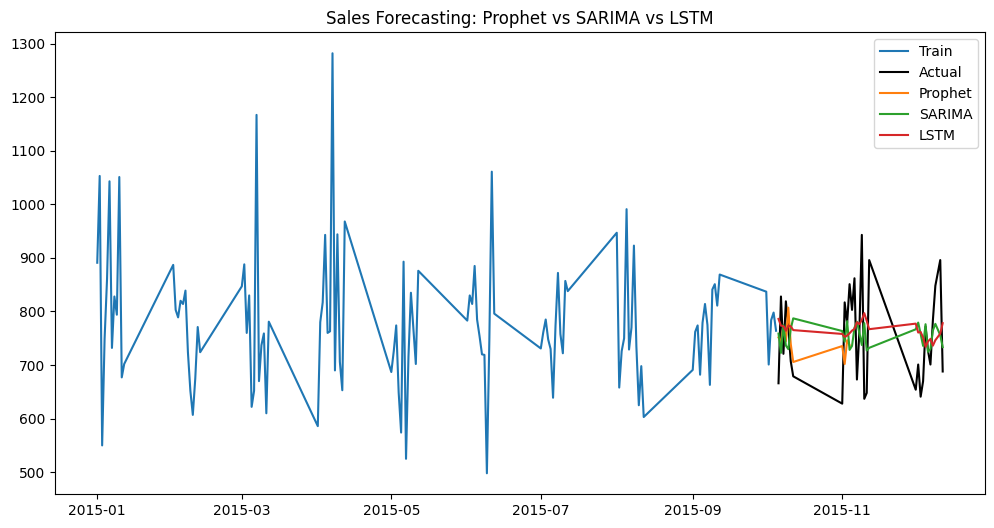

In [27]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from prophet import Prophet
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

# ---------------------------
# 1. Identify and prepare date column
# ---------------------------
if "date" in df.columns:
    date_col = "date"
elif "order_date" in df.columns:
    date_col = "order_date"
elif "ds" in df.columns:
    date_col = "ds"
else:
    raise KeyError("No suitable date column found! Expected one of: ['date', 'order_date', 'ds'].")

df[date_col] = pd.to_datetime(df[date_col])

# ---------------------------
# 2. Feature Engineering
# ---------------------------
df["day_of_week"] = df[date_col].dt.dayofweek   # 0=Mon ... 6=Sun
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df[date_col].dt.month
df["year"] = df[date_col].dt.year

# Holiday features
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df[date_col].min(), end=df[date_col].max())
df["is_holiday"] = df[date_col].isin(holidays).astype(int)

# Aggregate daily sales (if needed)
if "daily_quantity" in df.columns:
    daily_sales = df.groupby(date_col)["daily_quantity"].sum().reset_index()
else:
    raise KeyError("Expected a 'daily_quantity' column in df for sales.")

daily_sales.rename(columns={date_col: "ds", "daily_quantity": "y"}, inplace=True)


# ---------------------------
# 3. Train-test split
# ---------------------------
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

# ---------------------------
# 4. Prophet Model
# ---------------------------
prophet = Prophet()
prophet.fit(train)
future = prophet.make_future_dataframe(periods=len(test))
forecast = prophet.predict(future)

# Merge Prophet predictions with test set on 'ds'
prophet_merge = pd.merge(test, forecast[["ds", "yhat"]], on="ds", how="left")

# Drop rows where yhat is NaN
prophet_merge = prophet_merge.dropna(subset=["yhat"])

# Align true vs predicted
y_true = prophet_merge["y"].values
y_pred = prophet_merge["yhat"].values

# Calculate metrics
prophet_mape = mean_absolute_percentage_error(y_true, y_pred)
prophet_rmse = sqrt(mean_squared_error(y_true, y_pred))

# ---------------------------
# 5. SARIMA Model
# ---------------------------
sarima = sm.tsa.statespace.SARIMAX(train["y"], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima.fit(disp=False)
sarima_pred = sarima_fit.forecast(steps=len(test))

sarima_mape = mean_absolute_percentage_error(test["y"], sarima_pred)
sarima_rmse = sqrt(mean_squared_error(test["y"], sarima_pred))

# ---------------------------
# 6. LSTM Model
# ---------------------------
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[["y"]])

X_train, y_train = [], []
for i in range(7, len(scaled_train)):
    X_train.append(scaled_train[i-7:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

lstm = Sequential()
lstm.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], 1)))
lstm.add(Dense(1))
lstm.compile(optimizer="adam", loss="mse")
lstm.fit(X_train, y_train, epochs=20, verbose=0)

inputs = daily_sales["y"].values[-(len(test)+7):].reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test).reshape((len(X_test), 7, 1))
lstm_pred_scaled = lstm.predict(X_test, verbose=0)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()[:len(test)]

lstm_mape = mean_absolute_percentage_error(test["y"], lstm_pred)
lstm_rmse = sqrt(mean_squared_error(test["y"], lstm_pred))

# ---------------------------
# 7. Results
# ---------------------------
print("Model Comparison (MAPE, RMSE):")
print(f"Prophet: {prophet_mape:.3f}, {prophet_rmse:.2f}")
print(f"SARIMA: {sarima_mape:.3f}, {sarima_rmse:.2f}")
print(f"LSTM:   {lstm_mape:.3f}, {lstm_rmse:.2f}")

# ---------------------------
# 8. Plot Comparison
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Actual", color="black")
plt.plot(test["ds"], prophet_pred, label="Prophet")
plt.plot(test["ds"], sarima_pred, label="SARIMA")
plt.plot(test["ds"], lstm_pred, label="LSTM")
plt.legend()
plt.title("Sales Forecasting: Prophet vs SARIMA vs LSTM")
plt.show()


### Purchase Order

In [29]:
import pandas as pd

# -------------------------
# Step 1: Forecasted Sales
# -------------------------
forecast_sales = pd.DataFrame({
    "date": ["2025-09-06", "2025-09-06", "2025-09-07"],
    "pizza_name_id": ["Margherita", "Pepperoni", "Margherita"],
    "forecast_qty": [120, 80, 100]
})

# -------------------------
# Step 2: Pizza–Ingredient Mapping
# -------------------------
pizza_ingredients = pd.DataFrame({
    "pizza_name_id": ["Margherita", "Margherita", "Pepperoni", "Pepperoni"],
    "ingredient": ["Cheese", "Dough", "Cheese", "Dough"],
    "qty_per_pizza_g": [80, 200, 100, 200],
    "unit": ["g", "g", "g", "g"],
    "supplier": ["Supplier A", "Supplier B", "Supplier A", "Supplier B"]
})

# -------------------------
# Step 3: Calculate Ingredient Demand
# -------------------------
# Merge forecast with ingredient requirements
ingredient_demand = forecast_sales.merge(
    pizza_ingredients, on="pizza_name_id", how="left"
)

# Multiply forecasted sales × ingredient qty per pizza
ingredient_demand["total_qty_g"] = (
    ingredient_demand["forecast_qty"] * ingredient_demand["qty_per_pizza_g"]
)

# -------------------------
# Step 4: Aggregate by Ingredient
# -------------------------
purchase_order = (
    ingredient_demand.groupby(["ingredient", "unit", "supplier"], as_index=False)
    .agg({"total_qty_g": "sum"})
)

# Convert grams → kilograms for readability
purchase_order["total_qty_kg"] = purchase_order["total_qty_g"] / 1000

# -------------------------
# Final Purchase Order
# -------------------------
print("\n📦 Purchase Order:\n")
print(purchase_order[["ingredient", "total_qty_kg", "unit", "supplier"]])



📦 Purchase Order:

  ingredient  total_qty_kg unit    supplier
0     Cheese          25.6    g  Supplier A
1      Dough          60.0    g  Supplier B


In [31]:
import pandas as pd

# -------------------------
# Step 1: Forecasted Sales
# -------------------------
forecast_sales = pd.DataFrame({
    "date": ["2025-09-06", "2025-09-06", "2025-09-07"],
    "pizza_name_id": ["Margherita", "Pepperoni", "Margherita"],
    "forecast_qty": [120, 80, 100]
})

# -------------------------
# Step 2: Pizza–Ingredient Mapping
# -------------------------
pizza_ingredients = pd.DataFrame({
    "pizza_name_id": ["Margherita", "Margherita", "Pepperoni", "Pepperoni"],
    "ingredient": ["Cheese", "Dough", "Cheese", "Dough"],
    "qty_per_pizza_g": [80, 200, 100, 200],
    "unit": ["g", "g", "g", "g"],
    "supplier": ["Supplier A", "Supplier B", "Supplier A", "Supplier B"]
})

# -------------------------
# Step 3: Inventory Levels (example data)
# -------------------------
inventory = pd.DataFrame({
    "ingredient": ["Cheese", "Dough"],
    "current_stock_g": [5000, 30000]   # grams in stock
})

# -------------------------
# Step 4: Calculate Ingredient Demand
# -------------------------
ingredient_demand = forecast_sales.merge(pizza_ingredients, on="pizza_name_id", how="left")
ingredient_demand["total_qty_g"] = (
    ingredient_demand["forecast_qty"] * ingredient_demand["qty_per_pizza_g"]
)

purchase_order = (
    ingredient_demand.groupby(["ingredient", "unit", "supplier"], as_index=False)
    .agg({"total_qty_g": "sum"})
)

# -------------------------
# Step 5: Subtract Inventory → Net Requirement
# -------------------------
# Merge purchase order with inventory
po_with_inventory = purchase_order.merge(inventory, on="ingredient", how="left")

# Fill missing inventory with 0
po_with_inventory["current_stock_g"].fillna(0, inplace=True)

# Net requirement = demand – stock (cannot be negative)
po_with_inventory["net_qty_g"] = (
    po_with_inventory["total_qty_g"] - po_with_inventory["current_stock_g"]
).clip(lower=0)

# Convert grams → kilograms for readability
po_with_inventory["net_qty_kg"] = po_with_inventory["net_qty_g"] / 1000

# -------------------------
# Final Net Purchase Order
# -------------------------
net_purchase_order = po_with_inventory[
    ["ingredient", "supplier", "net_qty_kg", "unit"]
]

print("\n📦 Net Purchase Order:\n")
print(net_purchase_order)



📦 Net Purchase Order:

  ingredient    supplier  net_qty_kg unit
0     Cheese  Supplier A        20.6    g
1      Dough  Supplier B        30.0    g


### End-to-End Purchase Order Code

In [32]:
import pandas as pd

# -------------------------
# Step 1: Forecasted Sales (from Prophet/SARIMA/LSTM outputs)
# -------------------------
# Example: Replace this with your actual forecast output
forecast_sales = pd.DataFrame({
    "date": ["2025-09-06", "2025-09-06", "2025-09-07"],
    "pizza_name_id": ["Margherita", "Pepperoni", "Margherita"],
    "forecast_qty": [120, 80, 100]
})

# -------------------------
# Step 2: Pizza–Ingredient Mapping
# -------------------------
pizza_ingredients = pd.DataFrame({
    "pizza_name_id": ["Margherita", "Margherita", "Pepperoni", "Pepperoni"],
    "ingredient": ["Cheese", "Dough", "Cheese", "Dough"],
    "qty_per_pizza_g": [80, 200, 100, 200],
    "unit": ["g", "g", "g", "g"],
    "supplier": ["Supplier A", "Supplier B", "Supplier A", "Supplier B"]
})

# -------------------------
# Step 3: Inventory Levels (example, replace with real inventory DB)
# -------------------------
inventory = pd.DataFrame({
    "ingredient": ["Cheese", "Dough"],
    "current_stock_g": [5000, 30000]   # grams in stock
})

# -------------------------
# Step 4: Ingredient Demand
# -------------------------
ingredient_demand = forecast_sales.merge(pizza_ingredients, on="pizza_name_id", how="left")
ingredient_demand["total_qty_g"] = (
    ingredient_demand["forecast_qty"] * ingredient_demand["qty_per_pizza_g"]
)

purchase_order = (
    ingredient_demand.groupby(["ingredient", "unit", "supplier"], as_index=False)
    .agg({"total_qty_g": "sum"})
)

# -------------------------
# Step 5: Subtract Inventory → Net Requirement
# -------------------------
po_with_inventory = purchase_order.merge(inventory, on="ingredient", how="left")
po_with_inventory["current_stock_g"].fillna(0, inplace=True)

po_with_inventory["net_qty_g"] = (
    po_with_inventory["total_qty_g"] - po_with_inventory["current_stock_g"]
).clip(lower=0)

po_with_inventory["net_qty_kg"] = po_with_inventory["net_qty_g"] / 1000

# -------------------------
# Step 6: Final Purchase Order DataFrame
# -------------------------
net_purchase_order = po_with_inventory[
    ["ingredient", "supplier", "net_qty_kg", "unit"]
]

print("\n📦 Final Purchase Order:\n")
print(net_purchase_order)

# -------------------------
# Step 7: Export to Excel
# -------------------------
net_purchase_order.to_excel("dominos_purchase_order.xlsx", index=False)
print("\n✅ Purchase Order exported to 'dominos_purchase_order.xlsx'")



📦 Final Purchase Order:

  ingredient    supplier  net_qty_kg unit
0     Cheese  Supplier A        20.6    g
1      Dough  Supplier B        30.0    g

✅ Purchase Order exported to 'dominos_purchase_order.xlsx'
